In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.85",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
date_parse = lambda dates: pd.to_datetime(dates, format='%Y-%m')
stock = pd.read_csv('G:\PPRROOJJEECCTT\project_time_series\monthly-beer-production-in-austr.csv', sep = ',' , index_col= 'Month', parse_dates=["Month"], date_parser= date_parse)

In [3]:
stock.head()

Monthly beer production
Month                              
1956-01-01                     93.2
1956-02-01                     96.0
1956-03-01                     95.2
1956-04-01                     77.1
1956-05-01                     70.9

Since the ARIMA model requires the stock data to be a smooth and stationary series, we first need to perform the ADF (Augmented Dickey-Fuller) test. In brief terms, the ADF test evaluates the null hypothesis that the time series has a unit root (indicating non-stationarity) against the alternative hypothesis that it is stationary. By conducting the ADF test, we are assessing whether the data has consistent mean and variance over time. 

Given an observed time series $Y1, Y2, ..., Yn$ Dickey and Fuller consider three differential-form autoregressive equations to detect the presence of a unit root:

![ADF Differential equations](ADF_AutoRegressions.png) 

* t is the time index,

* α is an intercept constant called a drift,

* β is the coefficient on a time trend,

* γ is the coefficient presenting process root, i.e. the focus of testing,

* p is the lag order of the first-differences autoregressive process,

* e(t) is an independent identically distributes residual term. 

_(courtesy of rtmath.net)_

## Initial impression - blind analysis

### Overall trend

In [4]:
stock['Time'] = np.arange(len(stock.index)) 
stock.head()

Monthly beer production  Time
Month                                    
1956-01-01                     93.2     0
1956-02-01                     96.0     1
1956-03-01                     95.2     2
1956-04-01                     77.1     3
1956-05-01                     70.9     4

Text(0.5, 1.0, 'Time Plot Linear Trend')

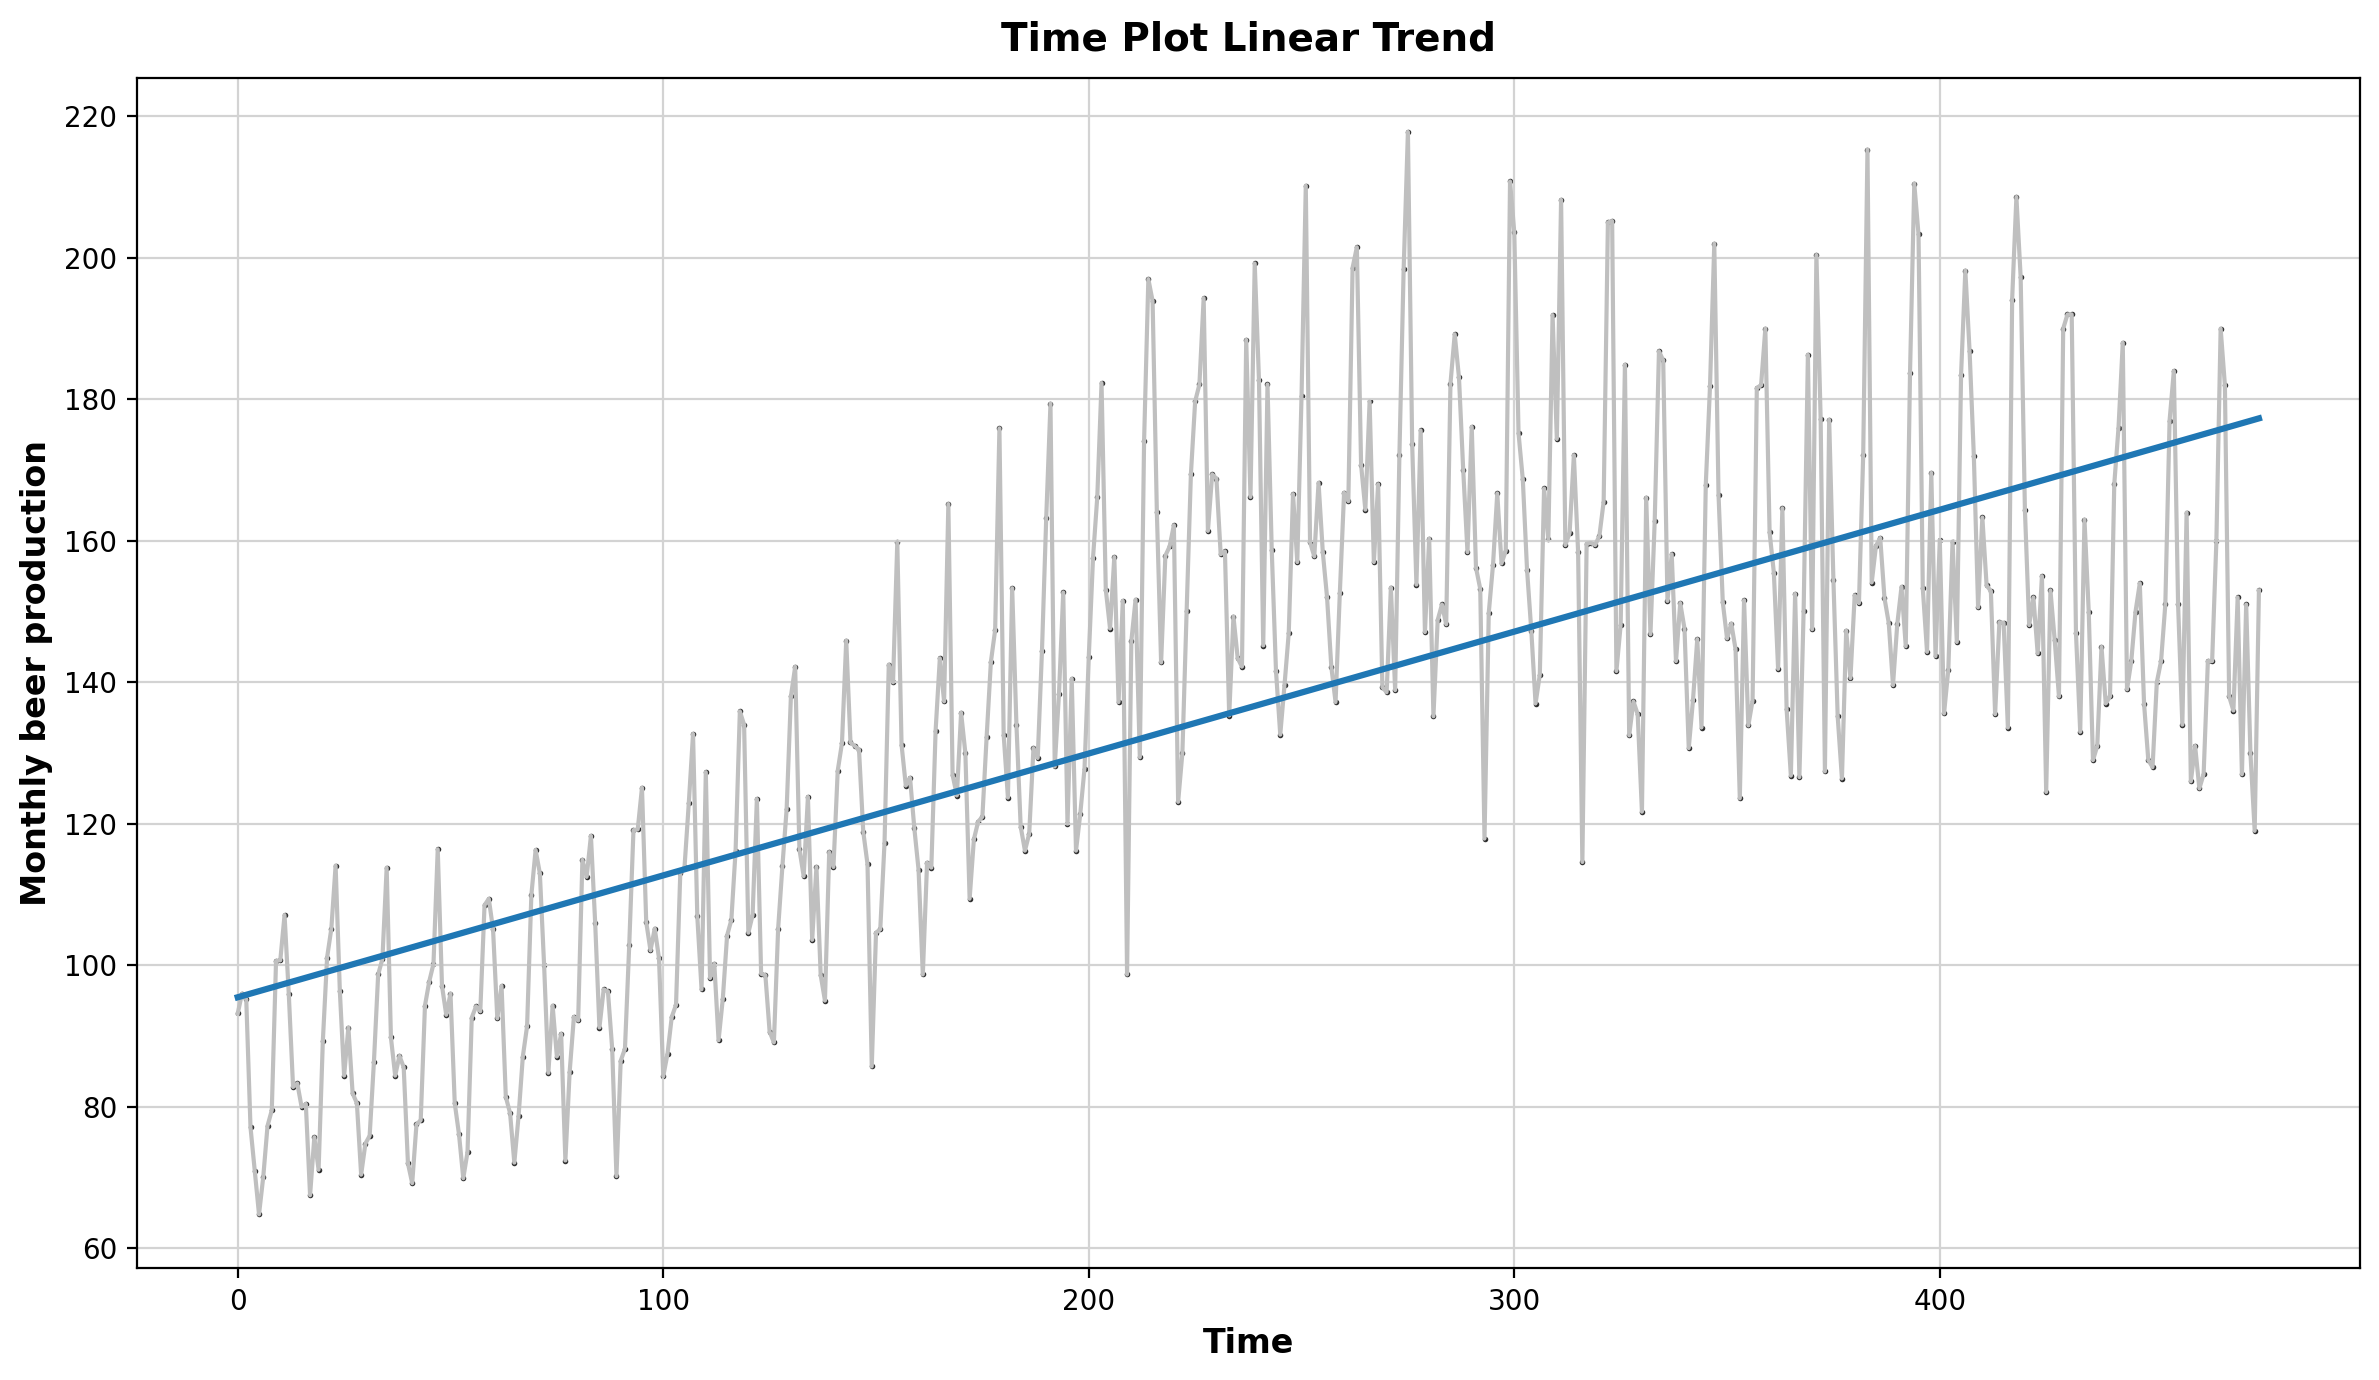

In [5]:
fig, ax = plt.subplots(figsize = (12, 7))
ax.plot('Time', 'Monthly beer production', data=stock, color='0.75')
ax = sns.regplot(x='Time', y='Monthly beer production', data=stock, ci=0.85, scatter_kws={'color': 'black', 
                                                                        's': 1,
                                                                        'marker': '.'})
plt.grid(color = 'lightgray')
ax.set_title('Time Plot Linear Trend')

* Overall Trend:
There appears to be a silght upward trend in the consumption of beer. On average, the values increase over time, but there are noticeable fluctuations around the trend line.


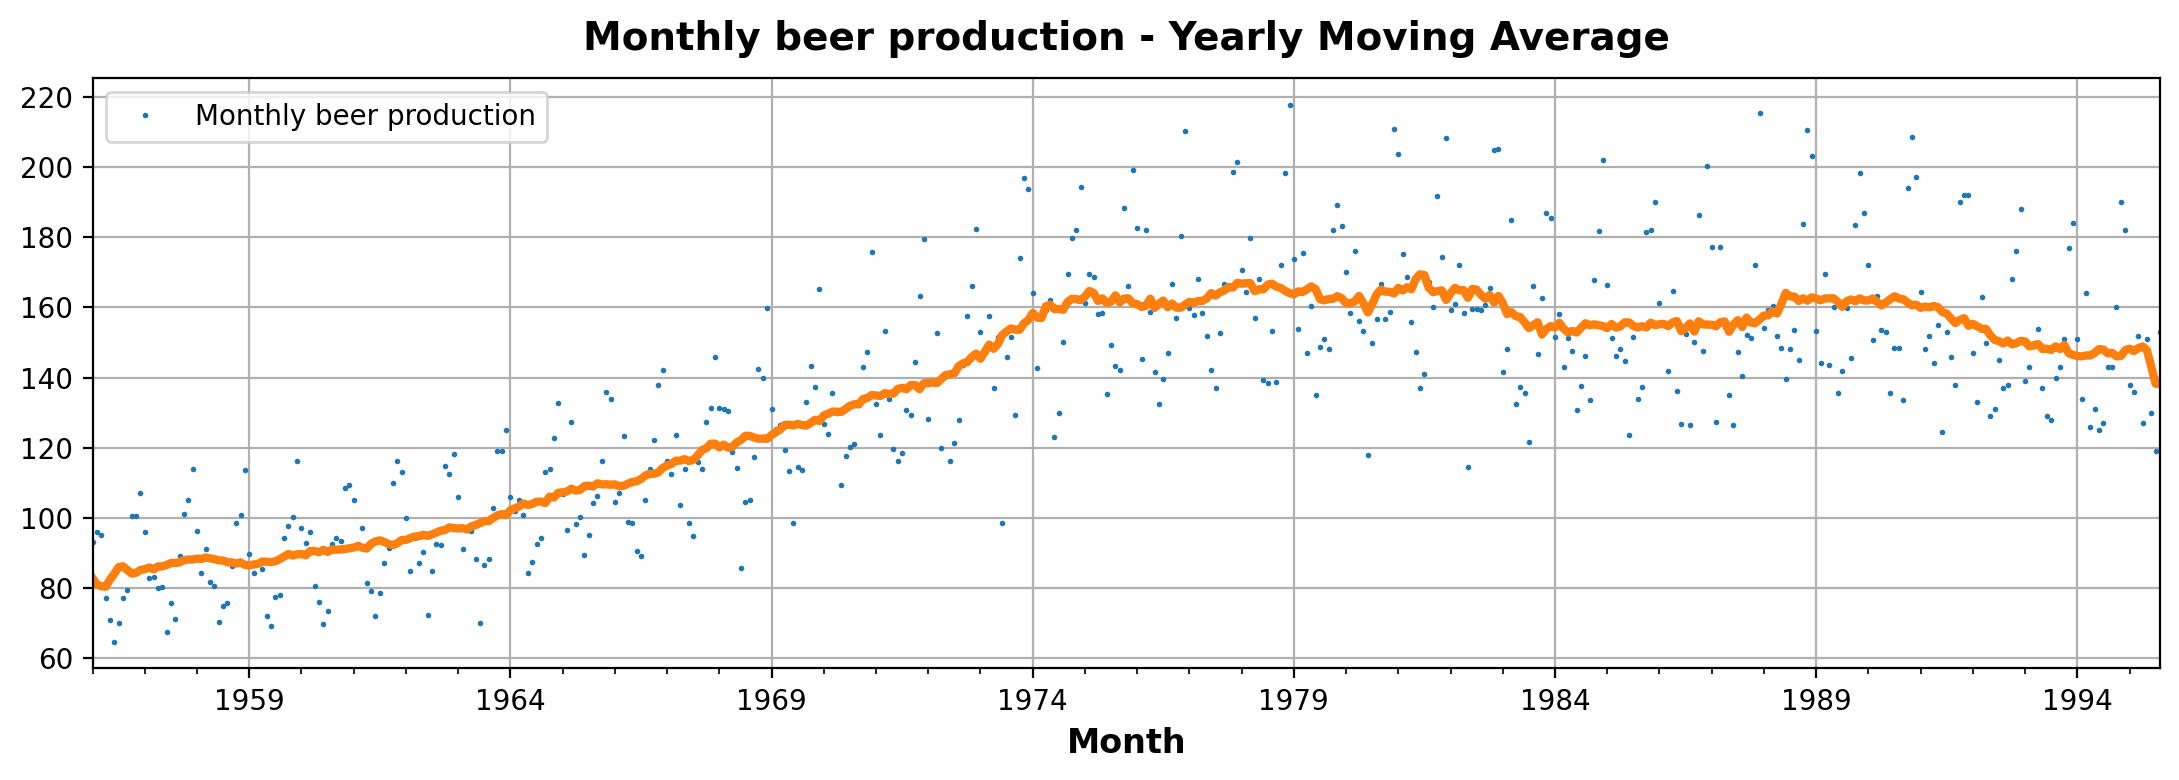

In [92]:
stock_close = pd.DataFrame(stock['Monthly beer production'])
moving_average = stock_close.rolling(
    window= 12,      
    center=True,      
    min_periods=6,  
).mean()             

ax = stock_close.plot(style=".", markersize=2)
moving_average.plot(
    ax=ax, linewidth=3, title="Monthly beer production - Yearly Moving Average", legend=False
)
plt.grid()
plt.show()

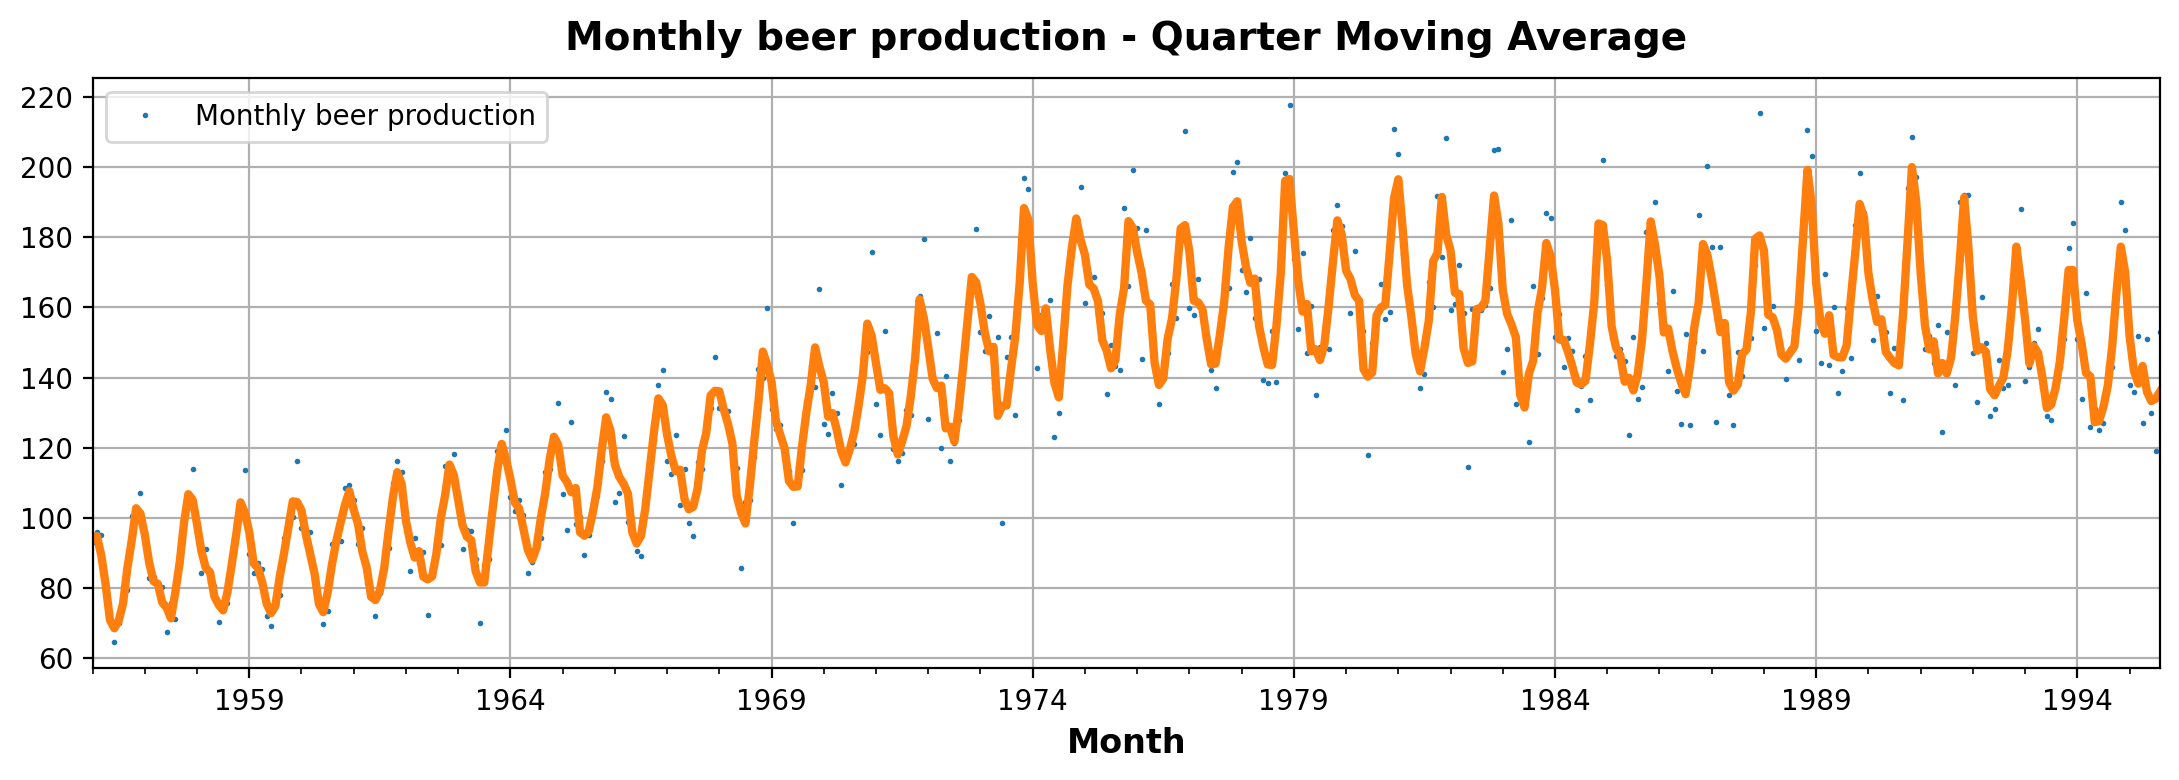

In [45]:
stock_close = pd.DataFrame(stock['Monthly beer production'])
moving_average = stock_close.rolling(
    window= 3,      
    center=True,      
    min_periods=2,  
).mean()             

ax = stock_close.plot(style=".", markersize=2)
moving_average.plot(
    ax=ax, linewidth=3, title="Monthly beer production - Quarter Moving Average", legend=False
)
plt.grid()
plt.show()

Trend Analysis:

* Overall Trend: The orange line shows a clear upward trend throughout the first 15 years of the survey. However, after 1974, the growth had stopped and the number of produced beer stayed relatively constant from then

Level Analysis:
* Early Period (1956- 1961): The monthly production was around , fluctuating below $25.
* Mid Period (1962-1974): The level increased
* Late Period (1974-1994): The stock price remained still

Analysis of the quarterly rolling mean of beer production reveals a clear cyclical pattern.:
The production of beer tended to increase towards the end of each year 




### Seasonality

In [97]:
data = stock['Monthly beer production']
data = data.asfreq('MS')
# data = data.interpolate(method='linear')

In [47]:
stock

Monthly beer production  Time
Month                                    
1956-01-01                     93.2     0
1956-02-01                     96.0     1
1956-03-01                     95.2     2
1956-04-01                     77.1     3
1956-05-01                     70.9     4
...                             ...   ...
1995-04-01                    127.0   471
1995-05-01                    151.0   472
1995-06-01                    130.0   473
1995-07-01                    119.0   474
1995-08-01                    153.0   475

[476 rows x 2 columns]

In [98]:
data

Month
1956-01-01     93.2
1956-02-01     96.0
1956-03-01     95.2
1956-04-01     77.1
1956-05-01     70.9
              ...  
1995-04-01    127.0
1995-05-01    151.0
1995-06-01    130.0
1995-07-01    119.0
1995-08-01    153.0
Freq: MS, Name: Monthly beer production, Length: 476, dtype: float64

#### for year

In [99]:
result_yearly_add = sm.tsa.seasonal_decompose(data, model='additive', period=12)


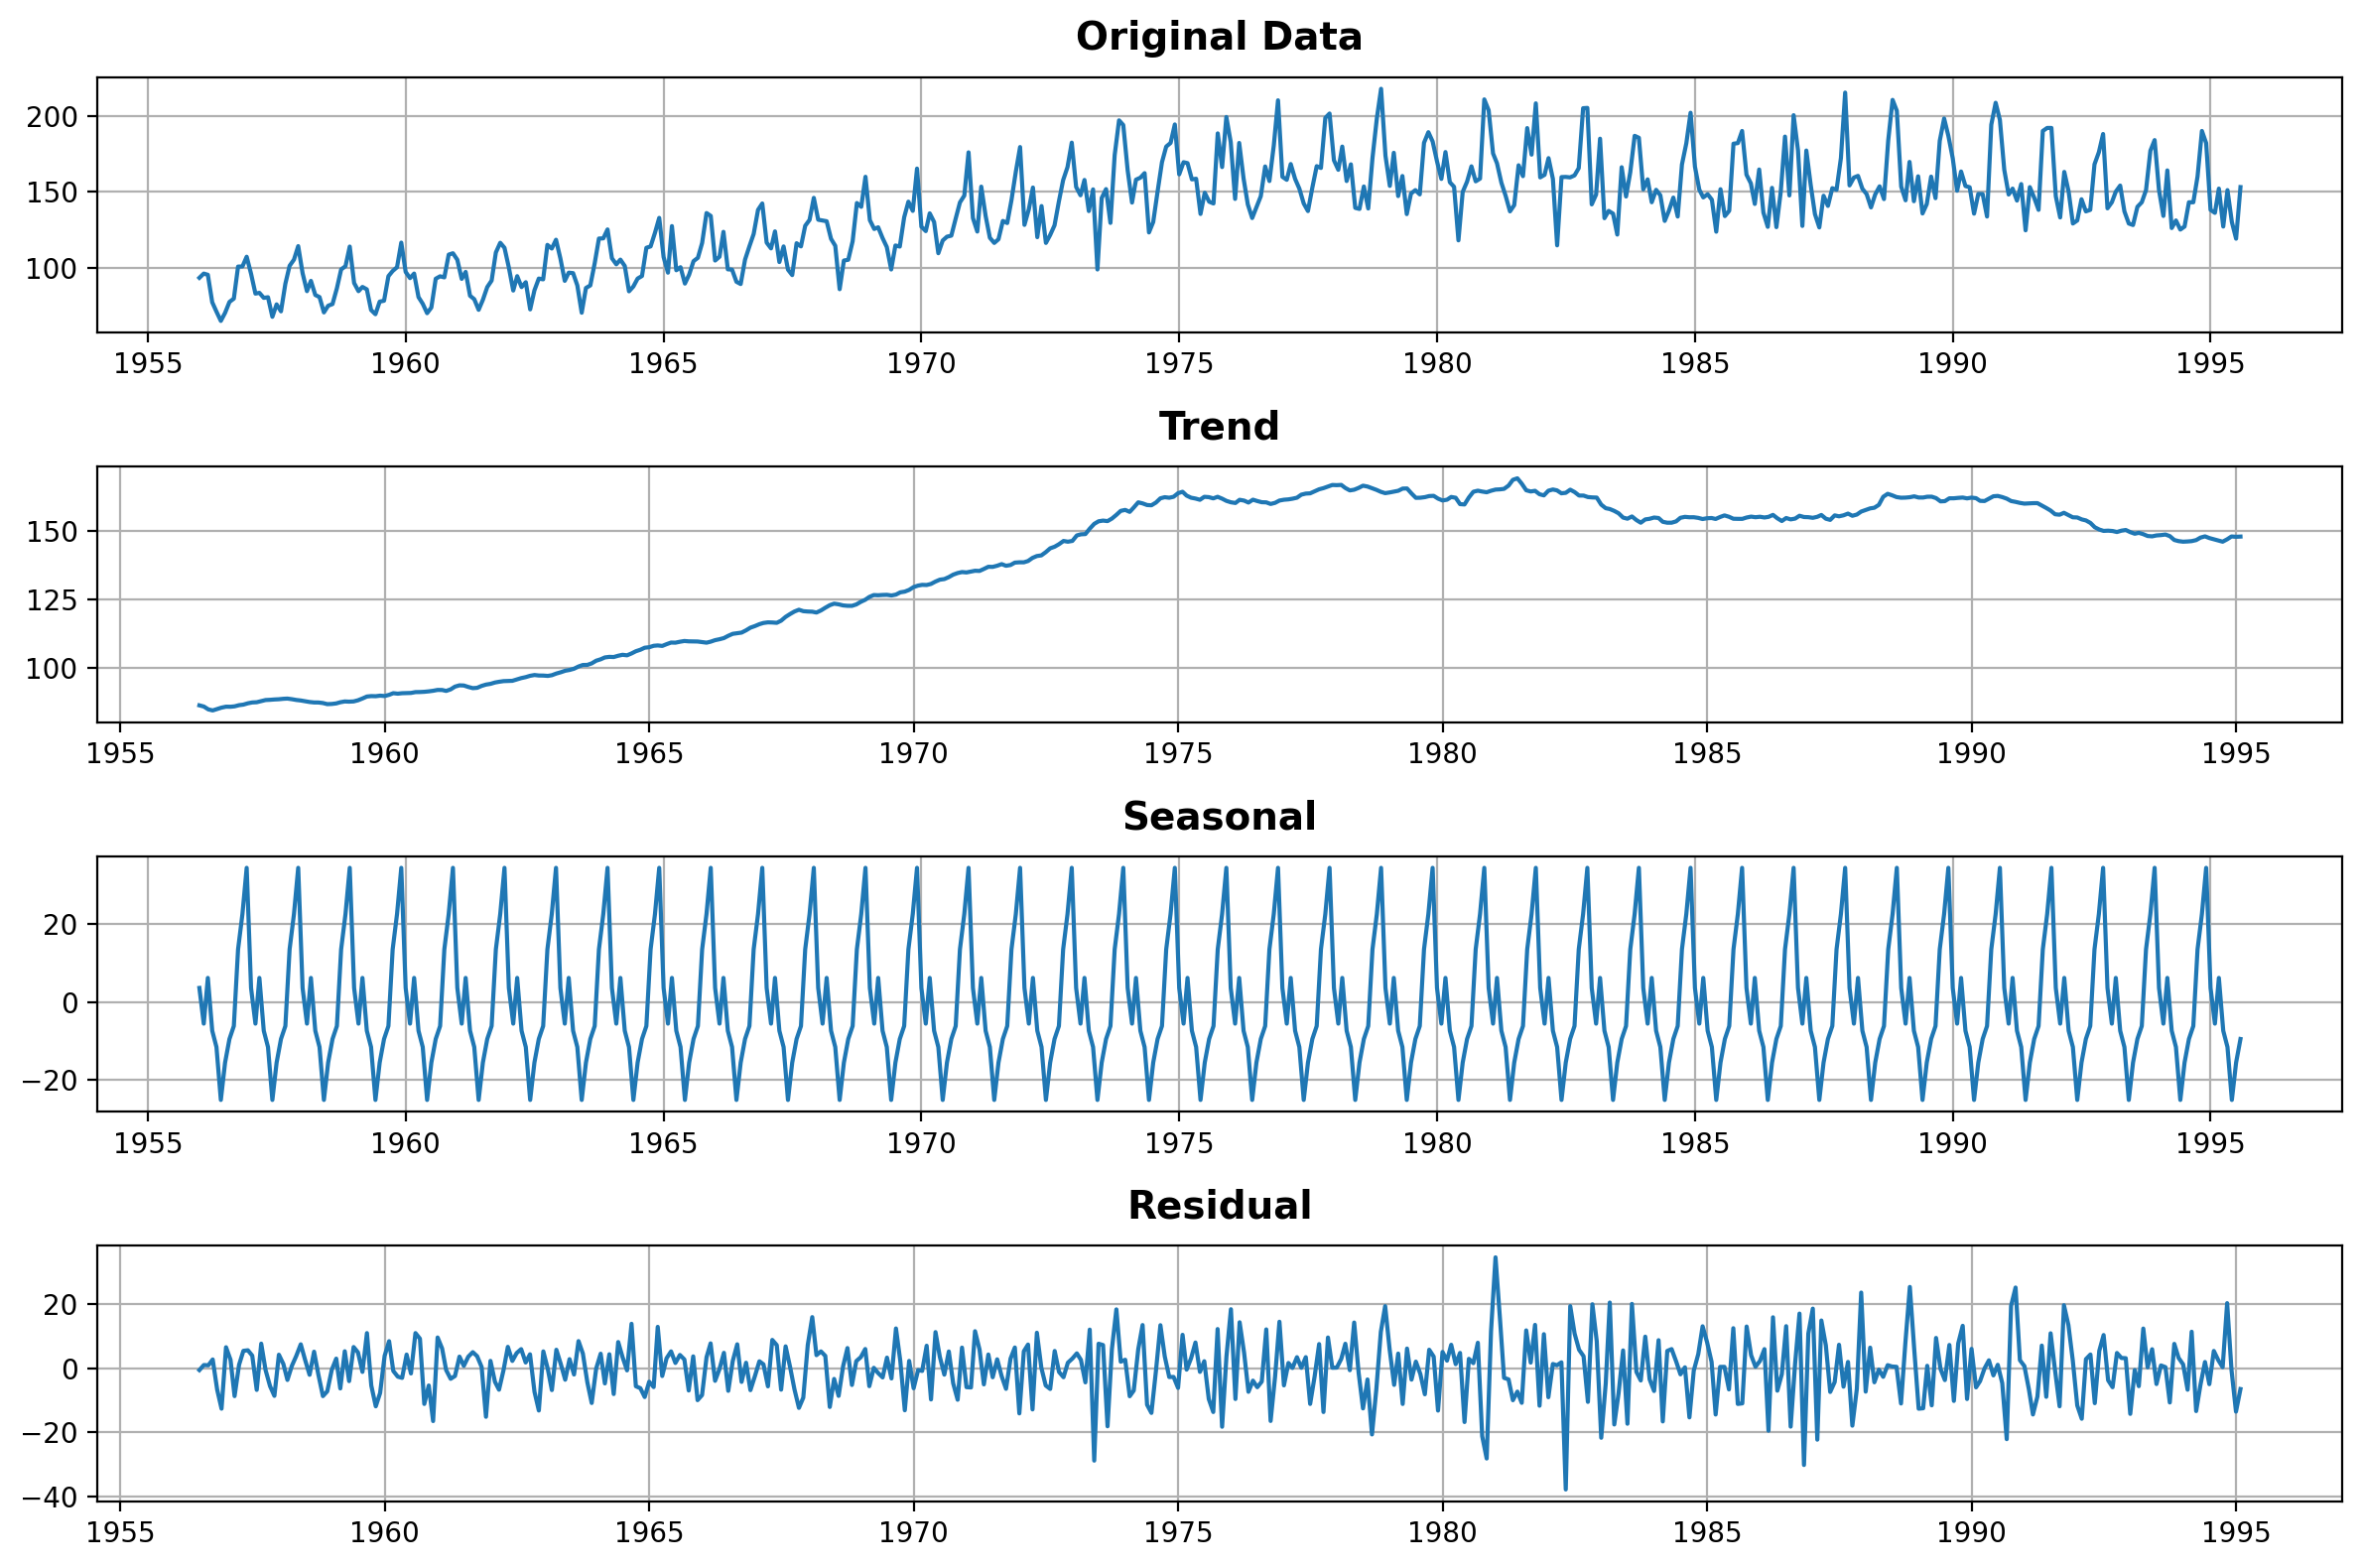

In [100]:

fig, axes = plt.subplots(4, 1, figsize=(12, 8))

components = ['Original Data', 'Trend', 'Seasonal', 'Residual']
for i, (component, data) in enumerate(zip(components, [data, result_yearly_add.trend, result_yearly_add.seasonal, result_yearly_add.resid])):
    ax = axes[i]
    ax.plot(data)
    ax.set_title(component)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [101]:
data = stock['Monthly beer production']
data = data.asfreq('MS')

Since the amplitude of seasonal plot appears to be constant overtime, we conclude that a additive model is suitable for this time series

In [102]:
deseasonalized_data_year = data - result_yearly_add.seasonal
deseasonalized_data_year

Month
1956-01-01     89.556828
1956-02-01    101.500204
1956-03-01     88.984367
1956-04-01     84.419126
1956-05-01     82.403226
                 ...    
1995-04-01    134.319126
1995-05-01    162.503226
1995-06-01    155.051691
1995-07-01    134.491764
1995-08-01    162.438772
Freq: MS, Length: 476, dtype: float64

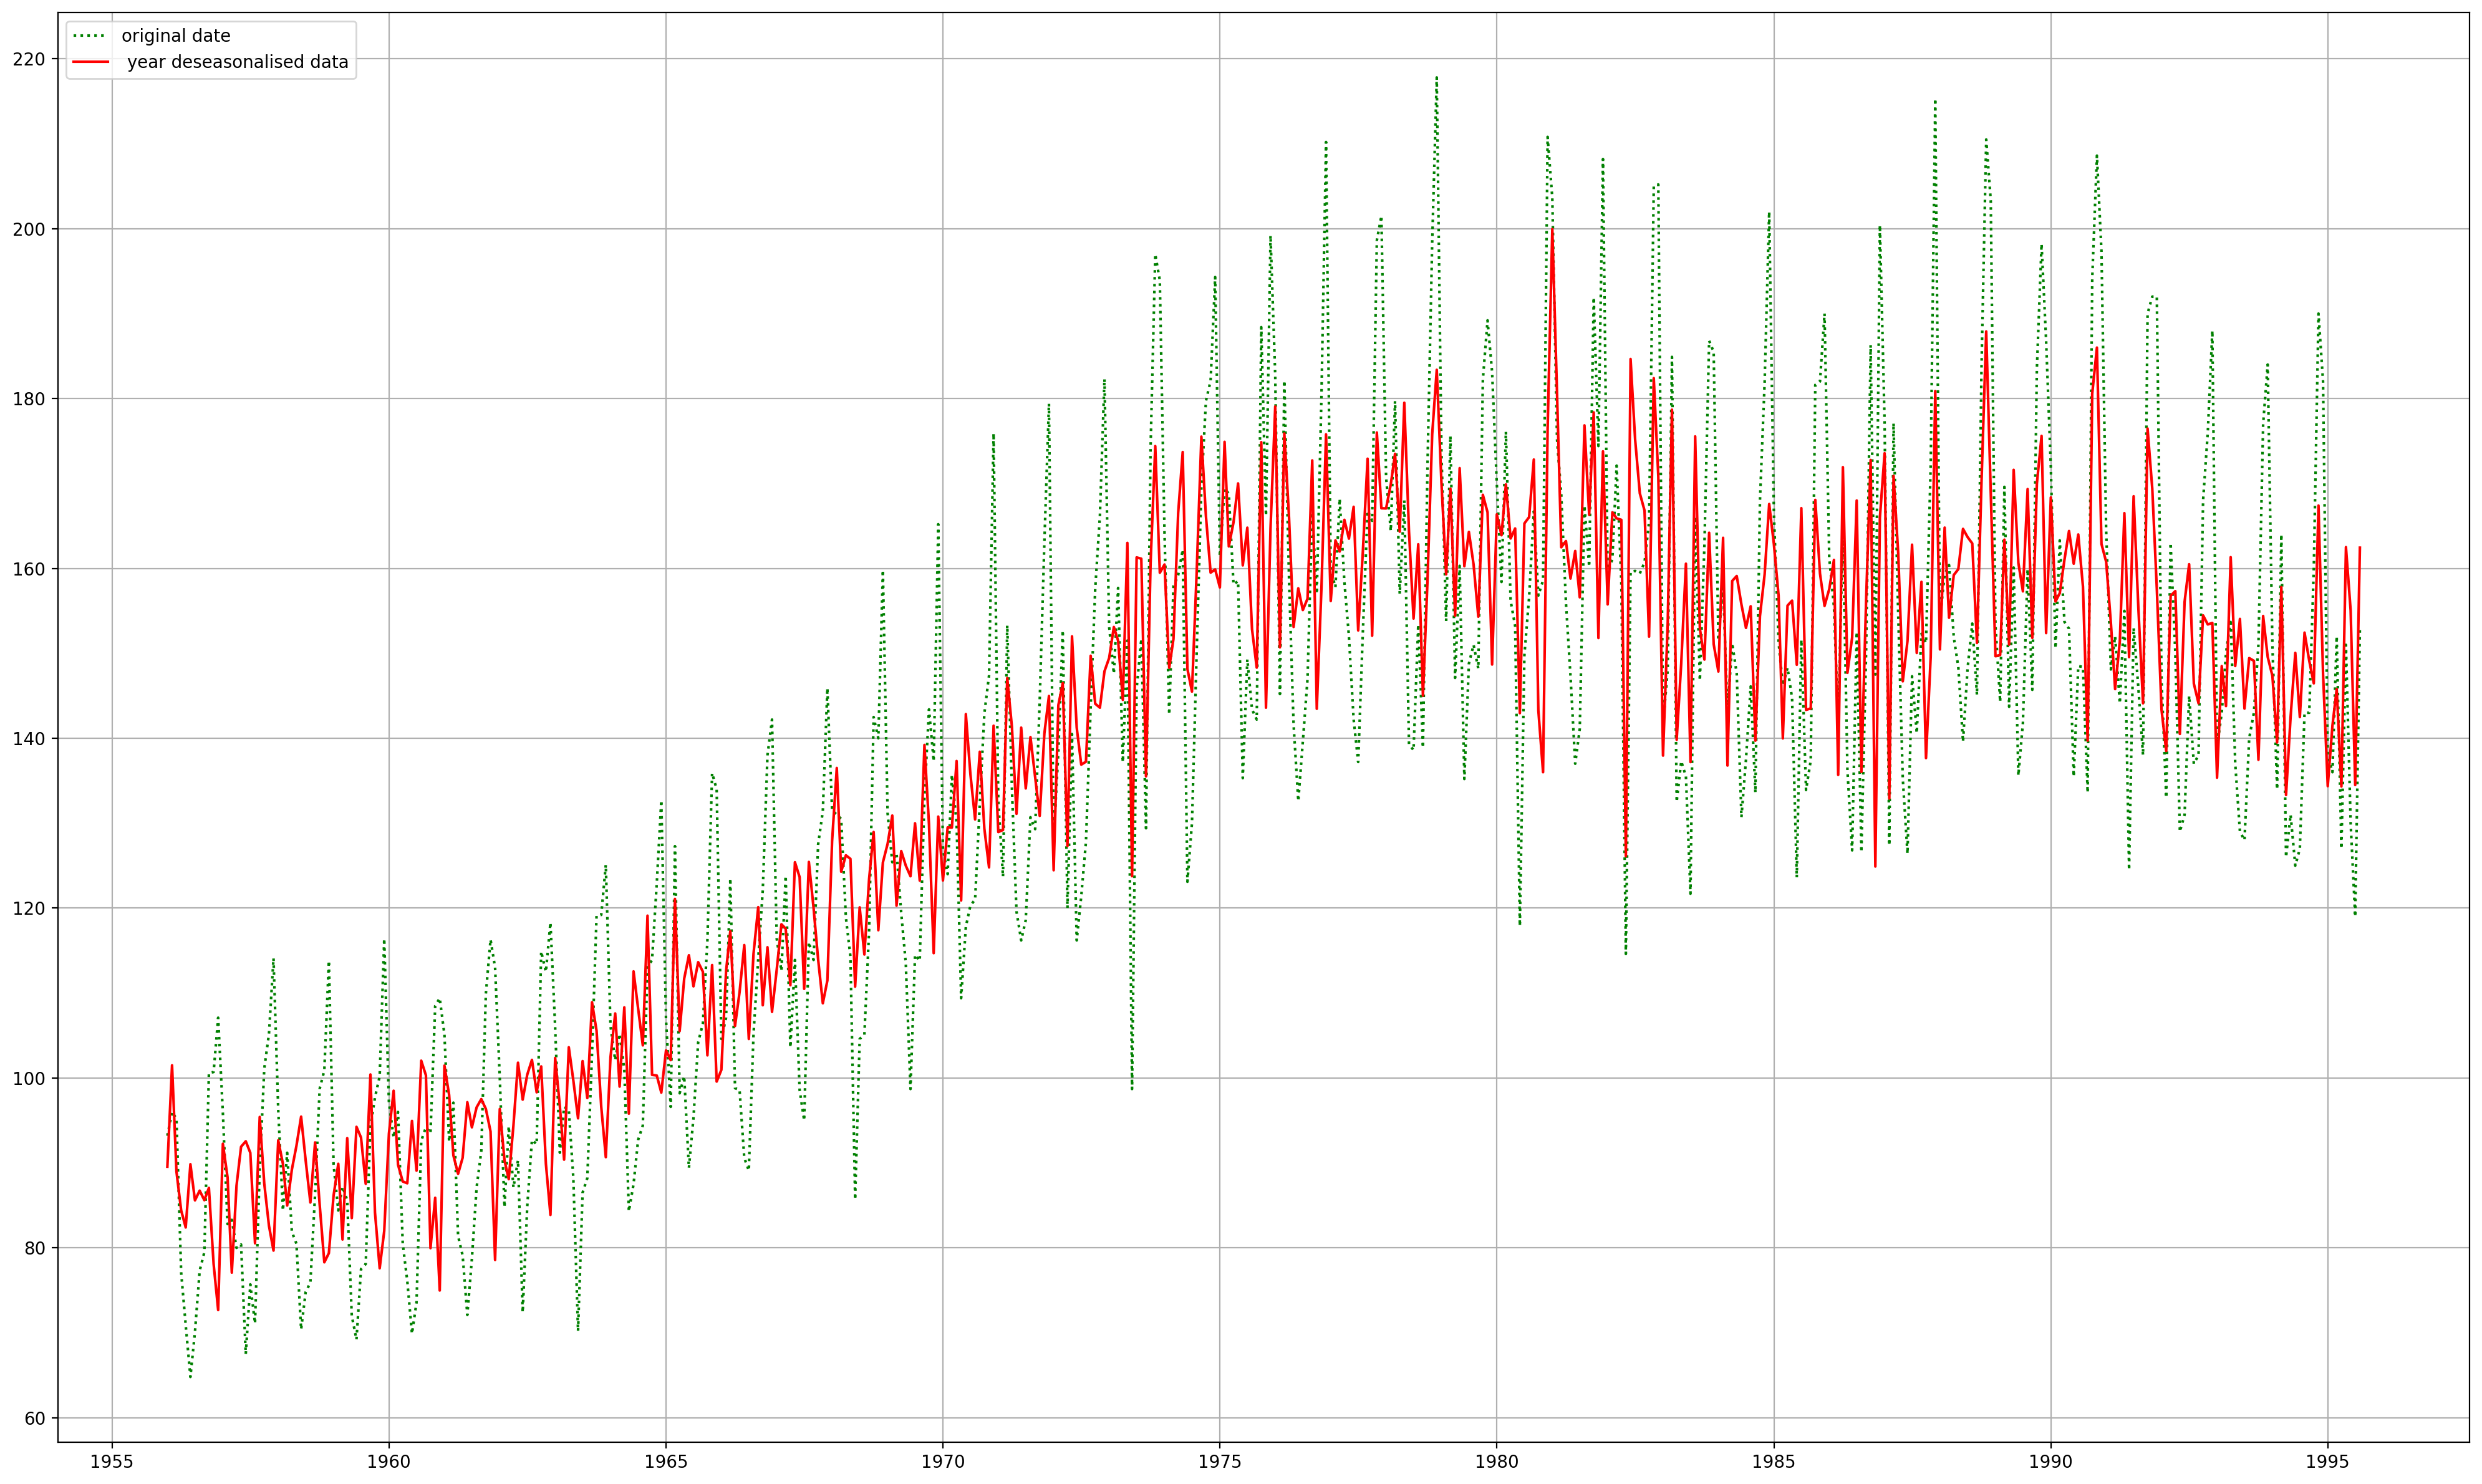

In [104]:

plt.figure(figsize= (20,12))
plt.plot(data,color = 'green', linestyle = ':',label = 'original date')
plt.grid()
plt.plot(deseasonalized_data_year,color = 'red', linestyle = '-',label = ' year deseasonalised data')
plt.legend(loc = 'upper left')

The original and the deseasonalised data showed significant difference, indicating that the data has substantial yearly seasonal influence

#### for quart

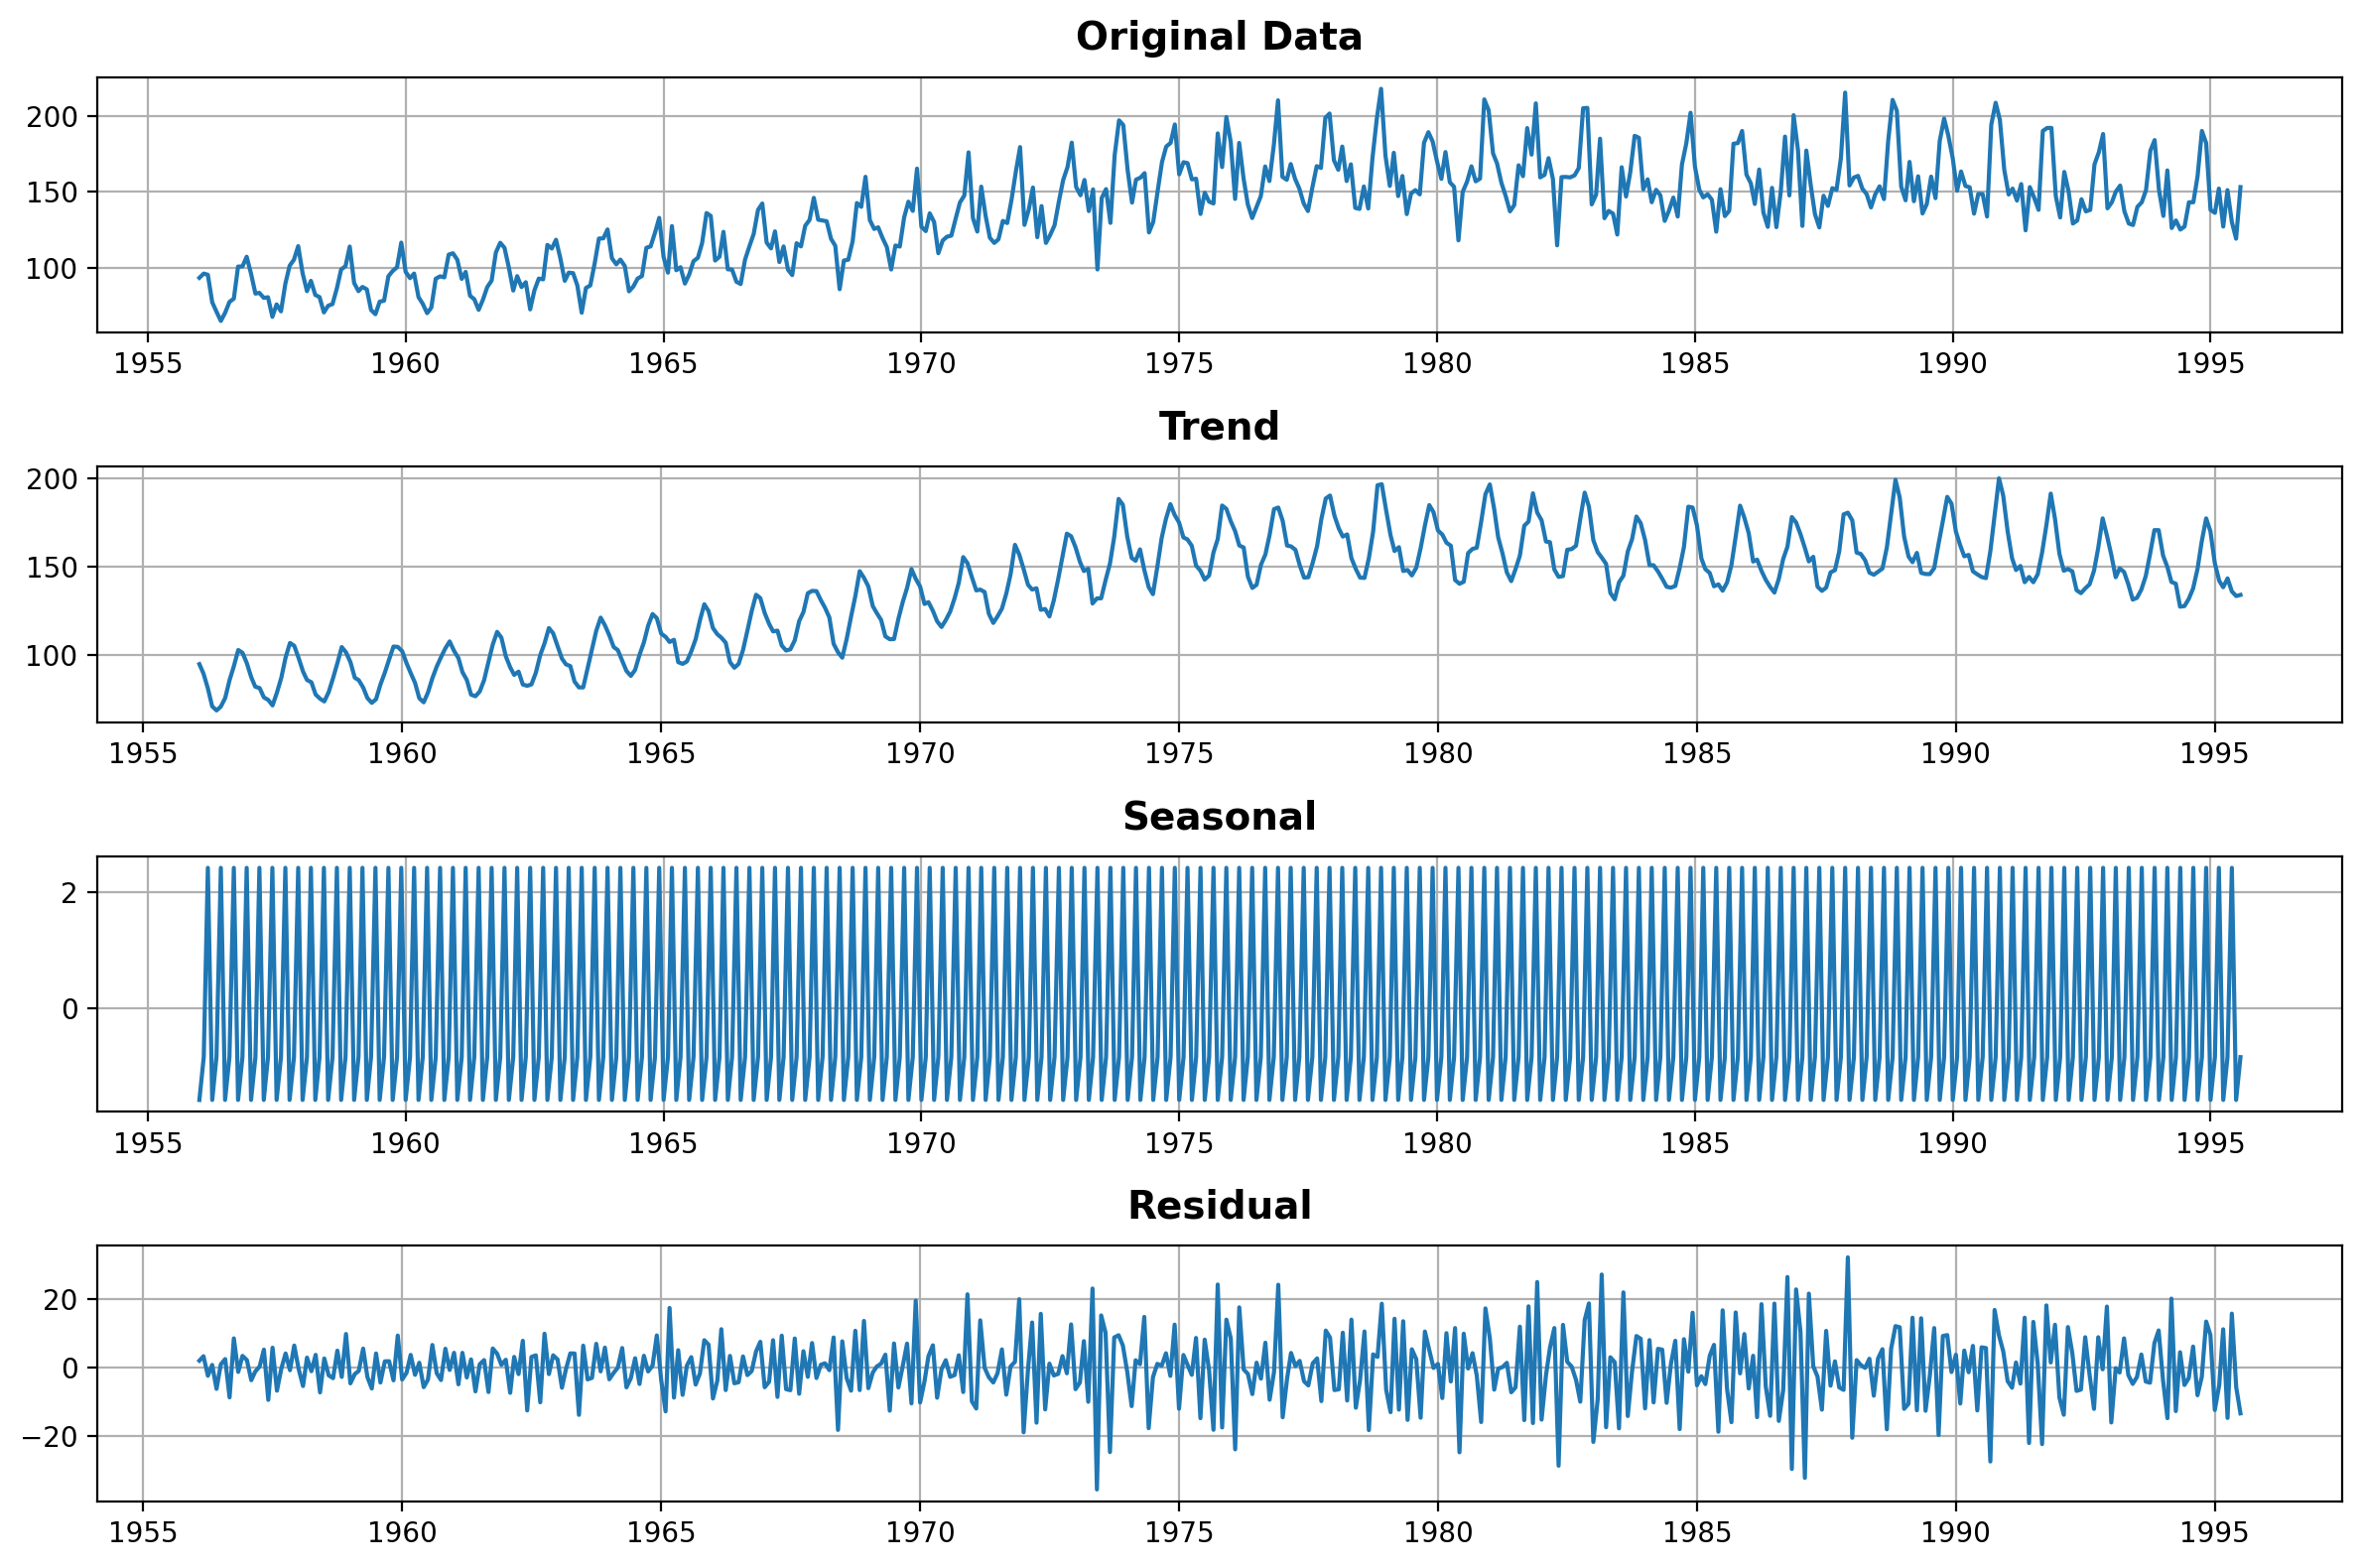

In [93]:
result_yearly_add = sm.tsa.seasonal_decompose(data, model='additive', period=3)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

components = ['Original Data', 'Trend', 'Seasonal', 'Residual']
for i, (component, data) in enumerate(zip(components, [data, result_yearly_add.trend, result_yearly_add.seasonal, result_yearly_add.resid])):
    ax = axes[i]
    ax.plot(data)
    ax.set_title(component)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [94]:
data = stock['Monthly beer production']
data = data.asfreq('MS')
deseasonalized_data_quart = data - result_yearly_add.seasonal

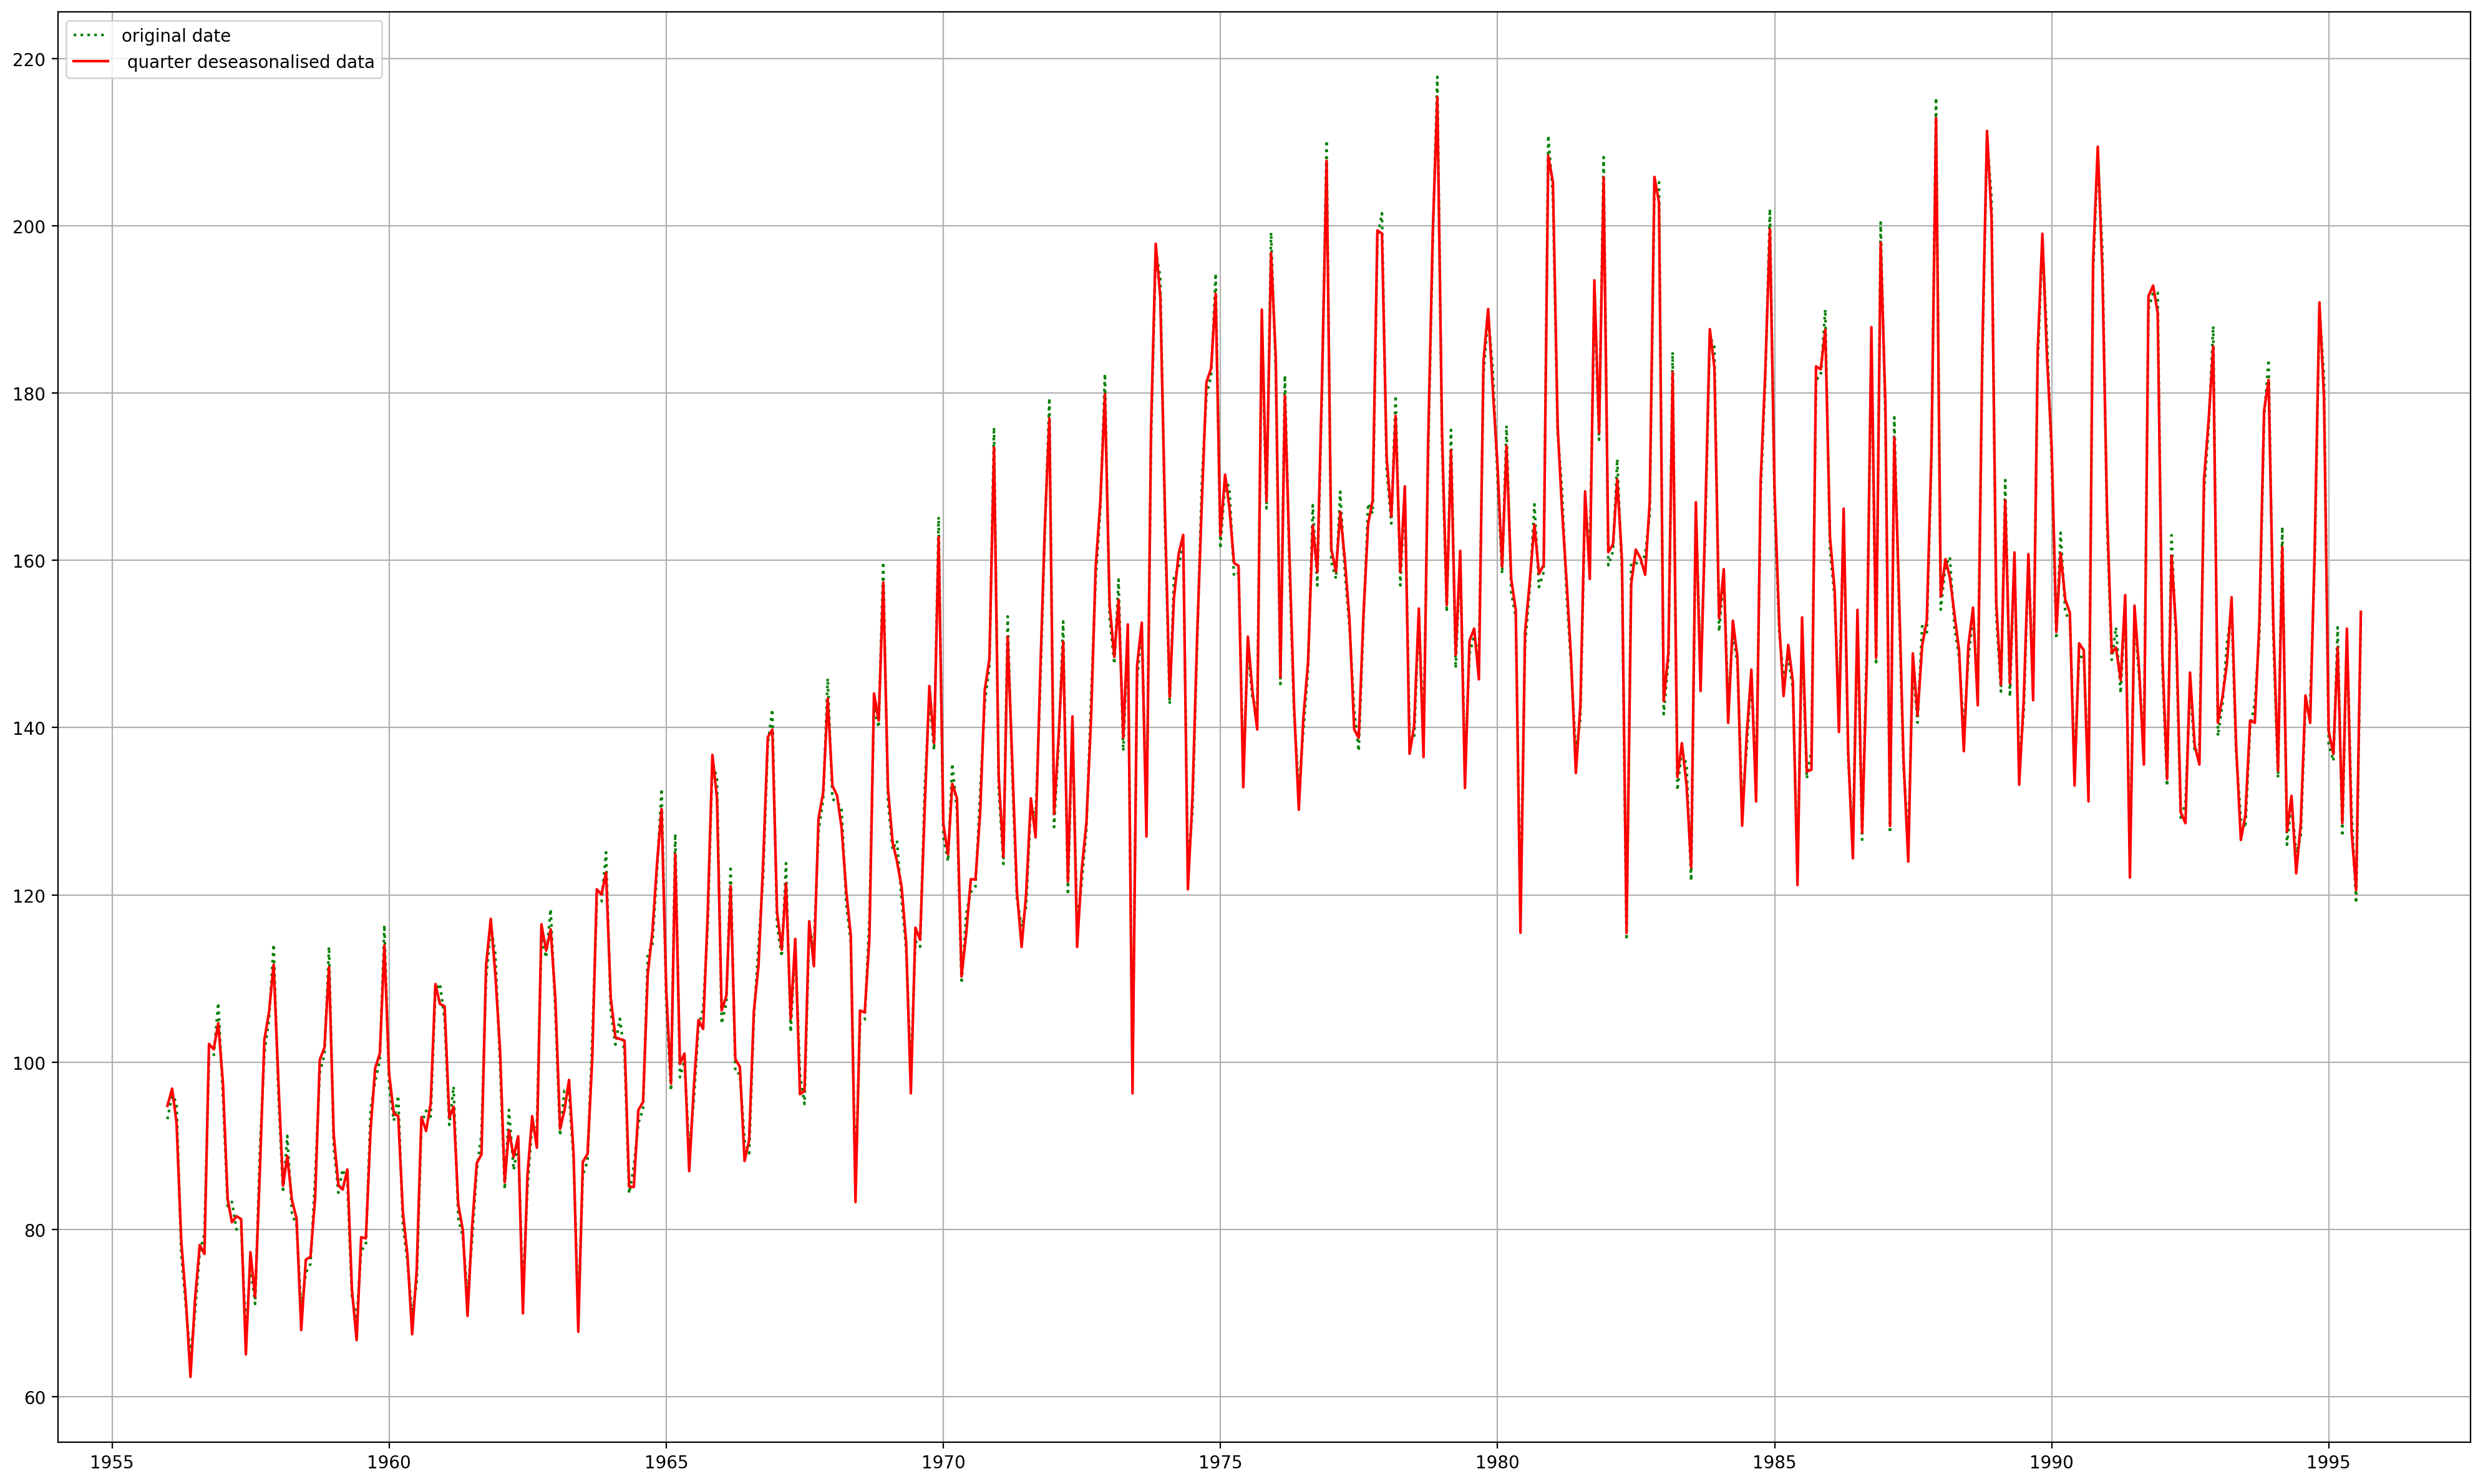

In [95]:
plt.figure(figsize= (20,12))
plt.plot(data,color = 'green', linestyle = ':',label = 'original date')
plt.grid()
plt.plot(deseasonalized_data_quart,color = 'red', linestyle = '-',label = ' quarter deseasonalised data')
plt.legend(loc = 'upper left')

## ARIMA manual analysis

In [106]:

deseasonalized_data = deseasonalized_data_year
deseasonalized_data

Month
1956-01-01     89.556828
1956-02-01    101.500204
1956-03-01     88.984367
1956-04-01     84.419126
1956-05-01     82.403226
                 ...    
1995-04-01    134.319126
1995-05-01    162.503226
1995-06-01    155.051691
1995-07-01    134.491764
1995-08-01    162.438772
Freq: MS, Length: 476, dtype: float64

Text(0.5, 1.0, 'Beer production in Australia')

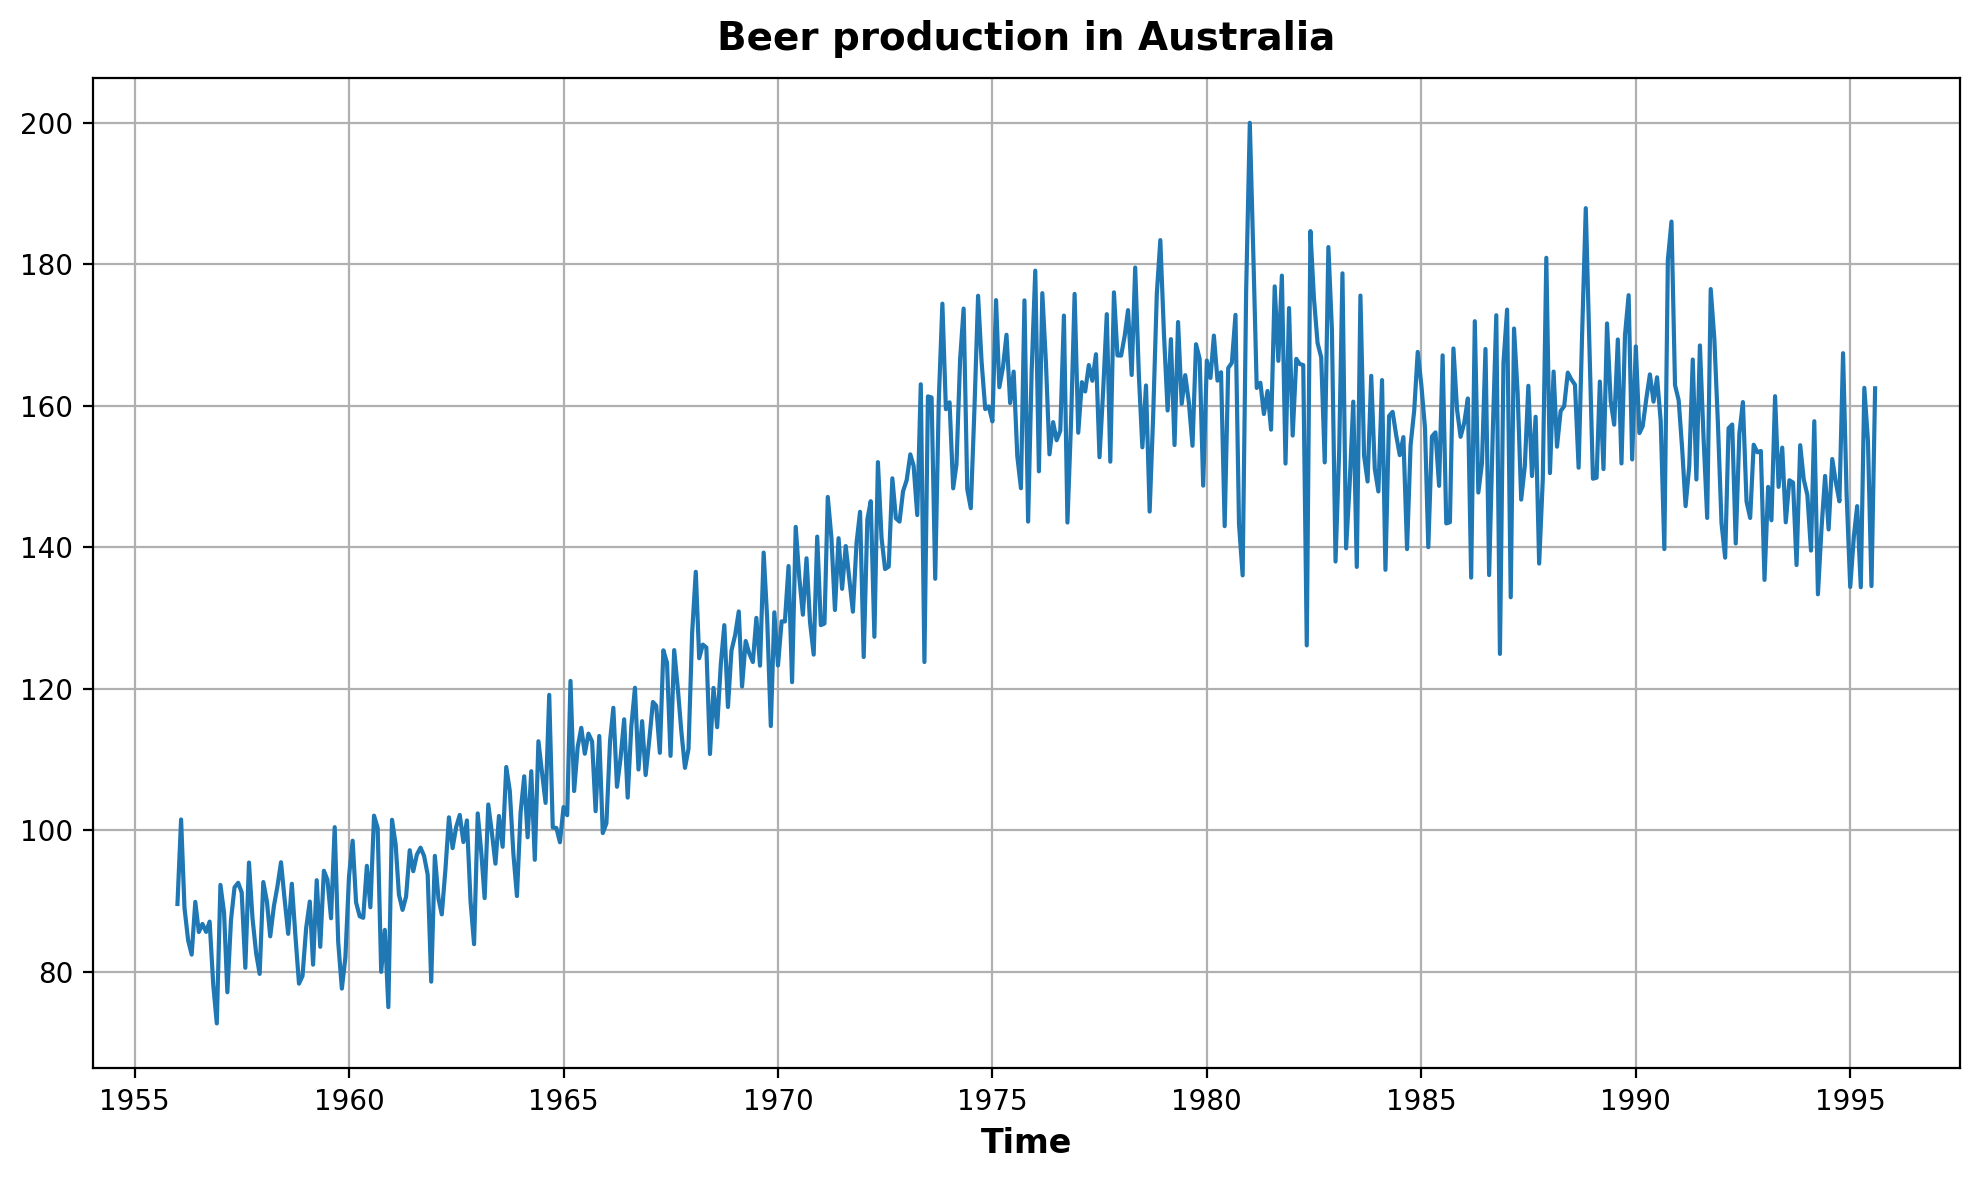

In [107]:
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.plot(deseasonalized_data)
plt.xlabel("Time")

plt.title("Beer production in Australia")



-> For the analysis to work, we need to make sure that the time series is stationary, meaning that is has constant statistical properties overtime (no changing level/trend/seasonality, and the noise component remains consistent), allowing for more reliable forecasting.

In [70]:
df_close = deseasonalized_data

In [71]:
df_close

Month
1956-01-01     89.556828
1956-02-01    101.500204
1956-03-01     88.984367
1956-04-01     84.419126
1956-05-01     82.403226
                 ...    
1995-04-01    134.319126
1995-05-01    162.503226
1995-06-01    155.051691
1995-07-01    134.491764
1995-08-01    162.438772
Freq: MS, Length: 476, dtype: float64

Result of ADF test: 

Test Stats                -2.425905
p-value                    0.134558
No. lags used             15.000000
No. observations used    460.000000
critical value (1%)       -3.444646
critical value (5%)       -2.867844
critical value (10%)      -2.570128
dtype: float64


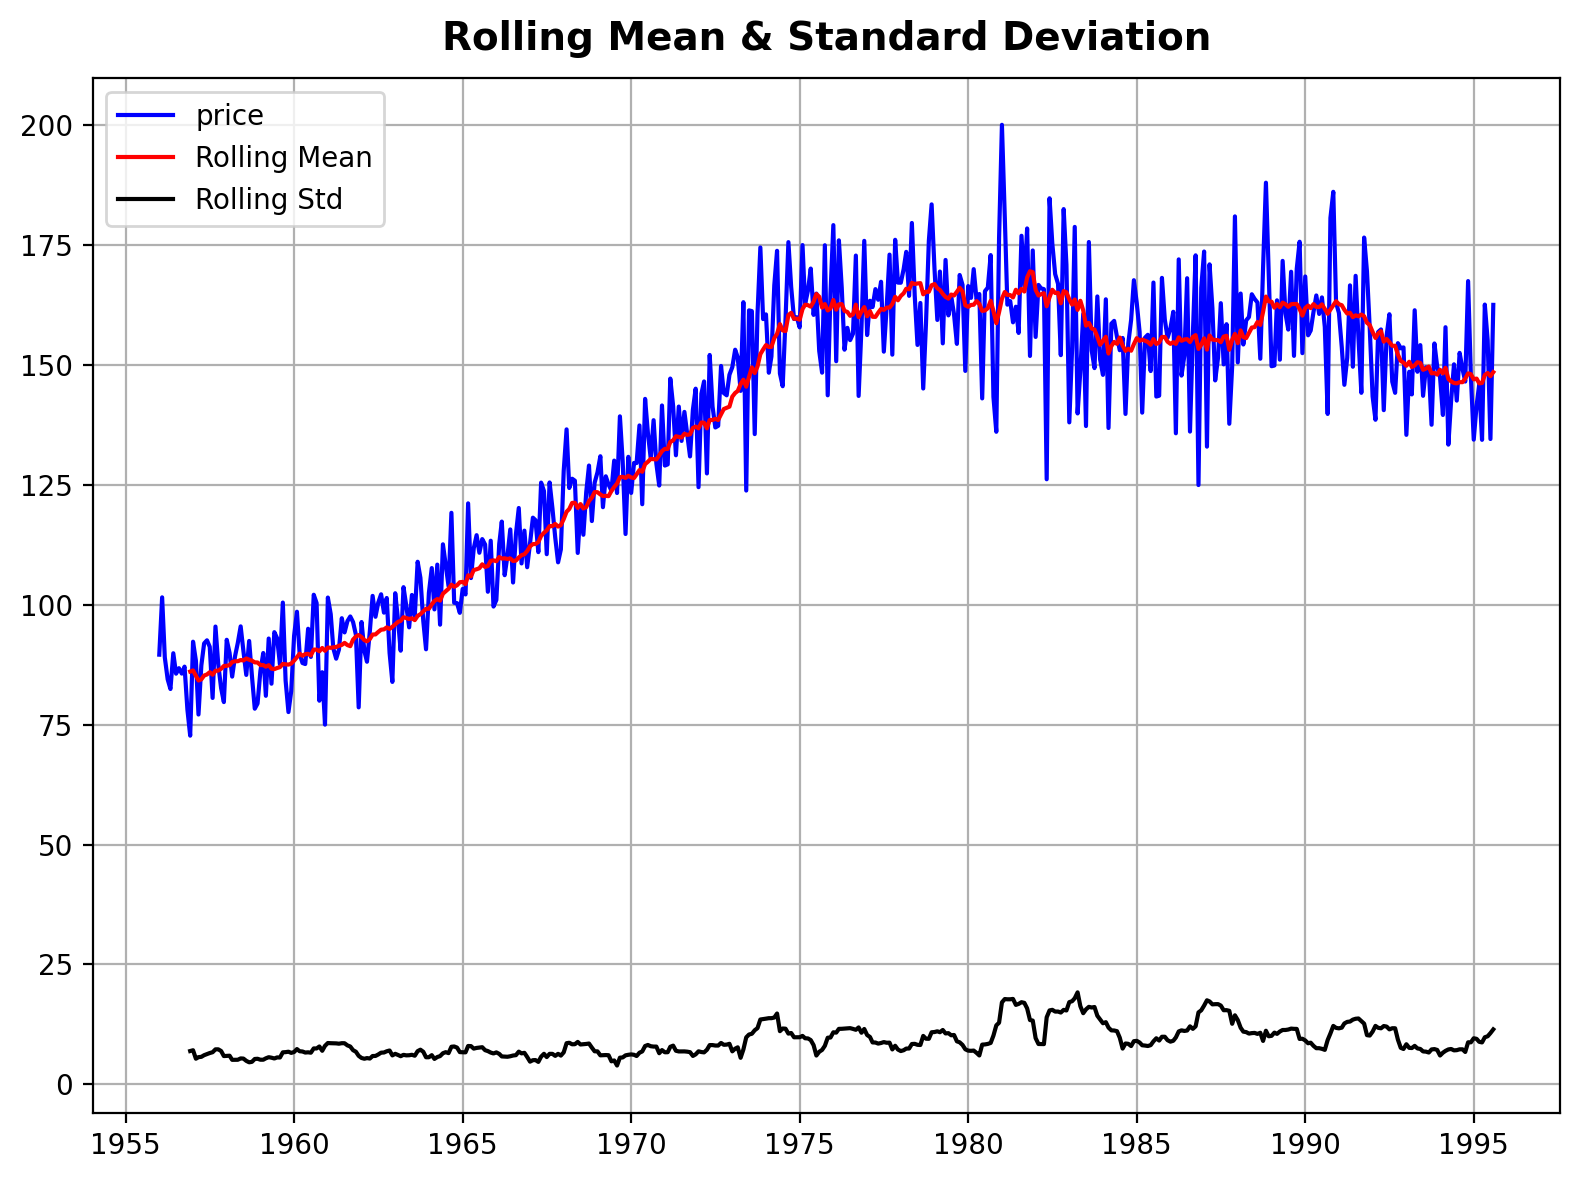

In [72]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean() #mean over a 12 month period
    rolling_std = timeseries.rolling(12).std() #standard deviation over a 12 month period
    
    plt.figure(figsize=(8, 6))
    plt.plot(timeseries, color = 'blue', label = 'price', linewidth = 1.5)
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean', linewidth = 1.5)
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std', linewidth = 1.5)
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid()
    
    print("Result of ADF test: \n")
    adf = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(adf[0:4], index = ['Test Stats', 'p-value', 'No. lags used', 'No. observations used'])
    for key, values in adf[4].items():
        output['critical value (%s)' %key] = values
    print(output)

test_stationarity(df_close)

With a p-value of 0.13 (exceeding 0.05), the null hypothesis cannot be rejected, meaning that our time series does not exhibit stationarity. 

- Difference transformation: first, we'll perform the difference transformation to reduce the p-value and change it into a smooth time sequence (reducing trend and seasonality). The difference transformation involves taking the difference between the consecutive observations in the time series. The resulting series can be analyzed better since it will have a more stable statistical behaviour. We will observe the results of model fitting on this time series, compared to

]

### Difference transformation - finding the d

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [74]:
df_close = pd.DataFrame(df_close)

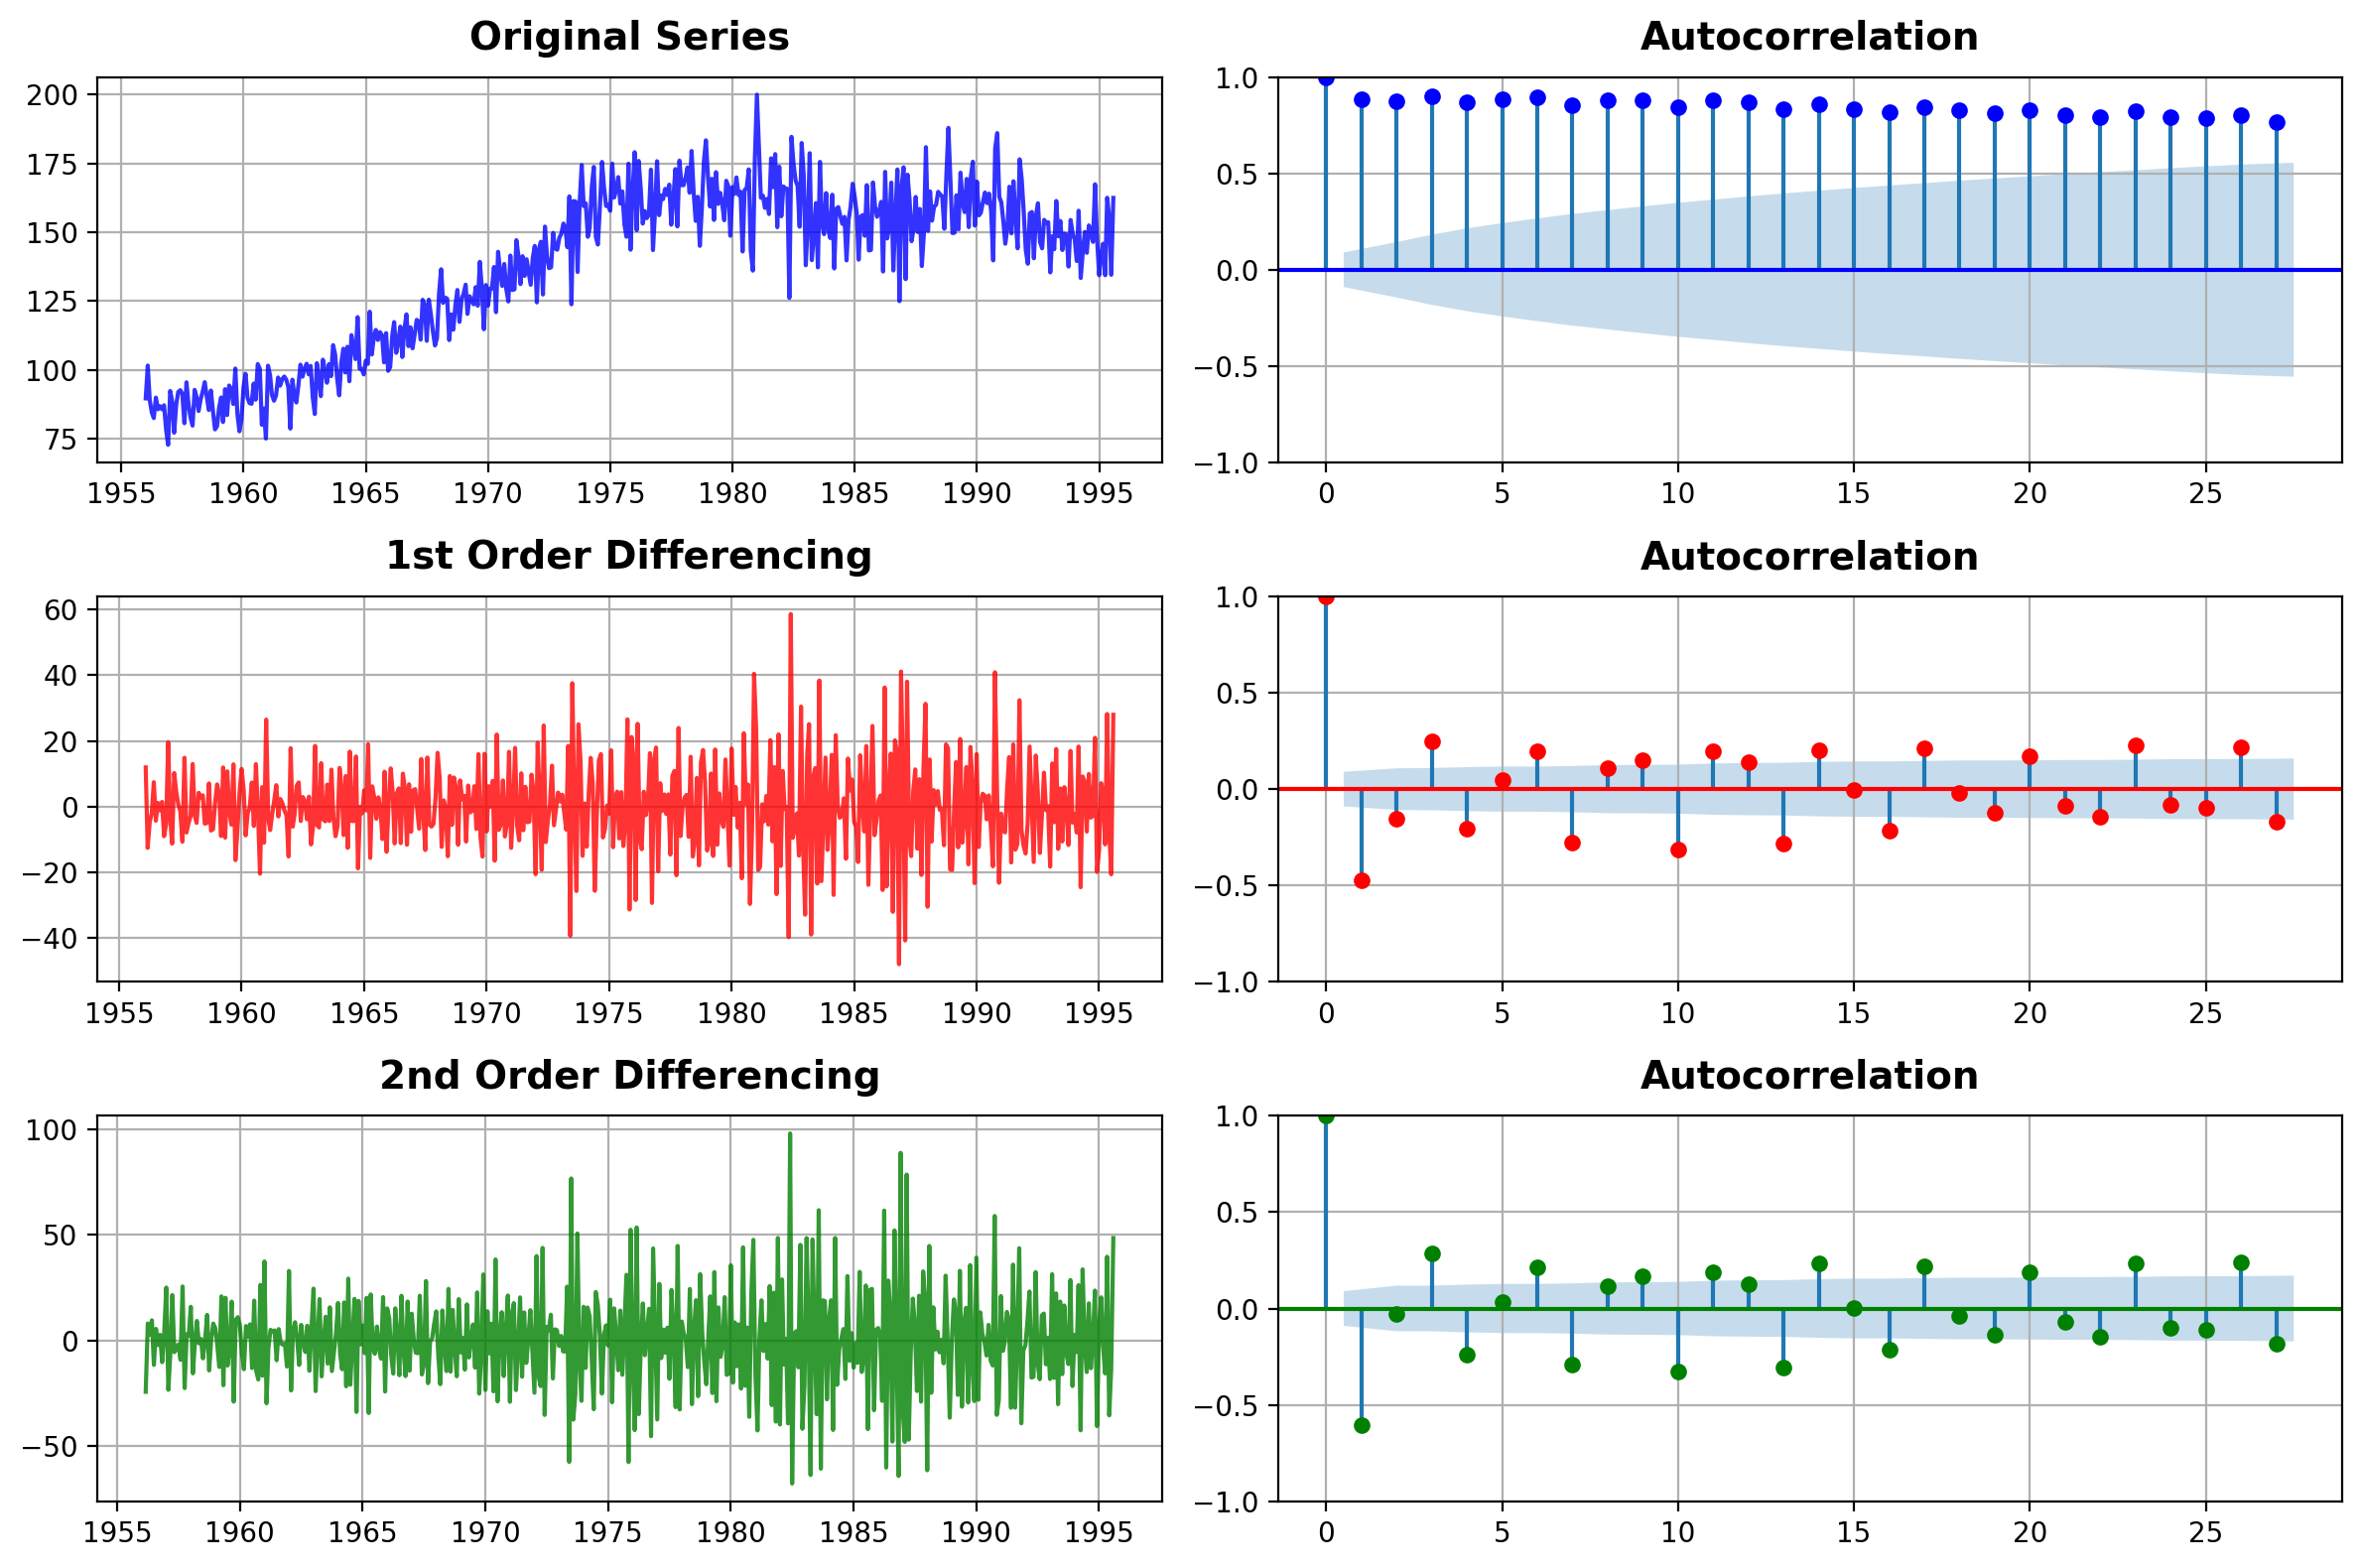

In [75]:
fig, axes = plt.subplots(3, 2, sharex=False, figsize = (12, 8))
axes[0, 0].plot(df_close[0], color = 'blue', alpha = 0.8); axes[0, 0].set_title('Original Series'); axes[0, 0].grid()
plot_acf(df_close[0], ax=axes[0, 1], color = 'blue'); axes[0, 1].grid()

# 1st Differencing
axes[1, 0].plot(df_close[0].diff(), color = 'red', alpha = 0.8); axes[1, 0].set_title('1st Order Differencing'); axes[1, 0].grid()
plot_acf(df_close[0].diff().dropna(), ax=axes[1, 1], color = 'red'); axes[1, 1].grid()

# 2nd Differencing
axes[2, 0].plot(df_close[0].diff().diff(), color = 'green', alpha = 0.8); axes[2, 0].set_title('2nd Order Differencing'); axes[2, 0].grid()
plot_acf(df_close[0].diff().diff().dropna(), ax=axes[2, 1], color = 'green'); axes[2, 1].grid()

plt.show()

As seen in the plot above, we are able to reach stationarity with order of differencing = 1. To further confirm this, we'll perform ADF on the data after differentiation.

Result of ADF test on closing data of difference order 1: 

Test Stats              -6.996674e+00
p-value                  7.502693e-10
No. lags used            1.400000e+01
No. observations used    4.600000e+02
critical value (1%)     -3.444646e+00
critical value (5%)     -2.867844e+00
critical value (10%)    -2.570128e+00
dtype: float64


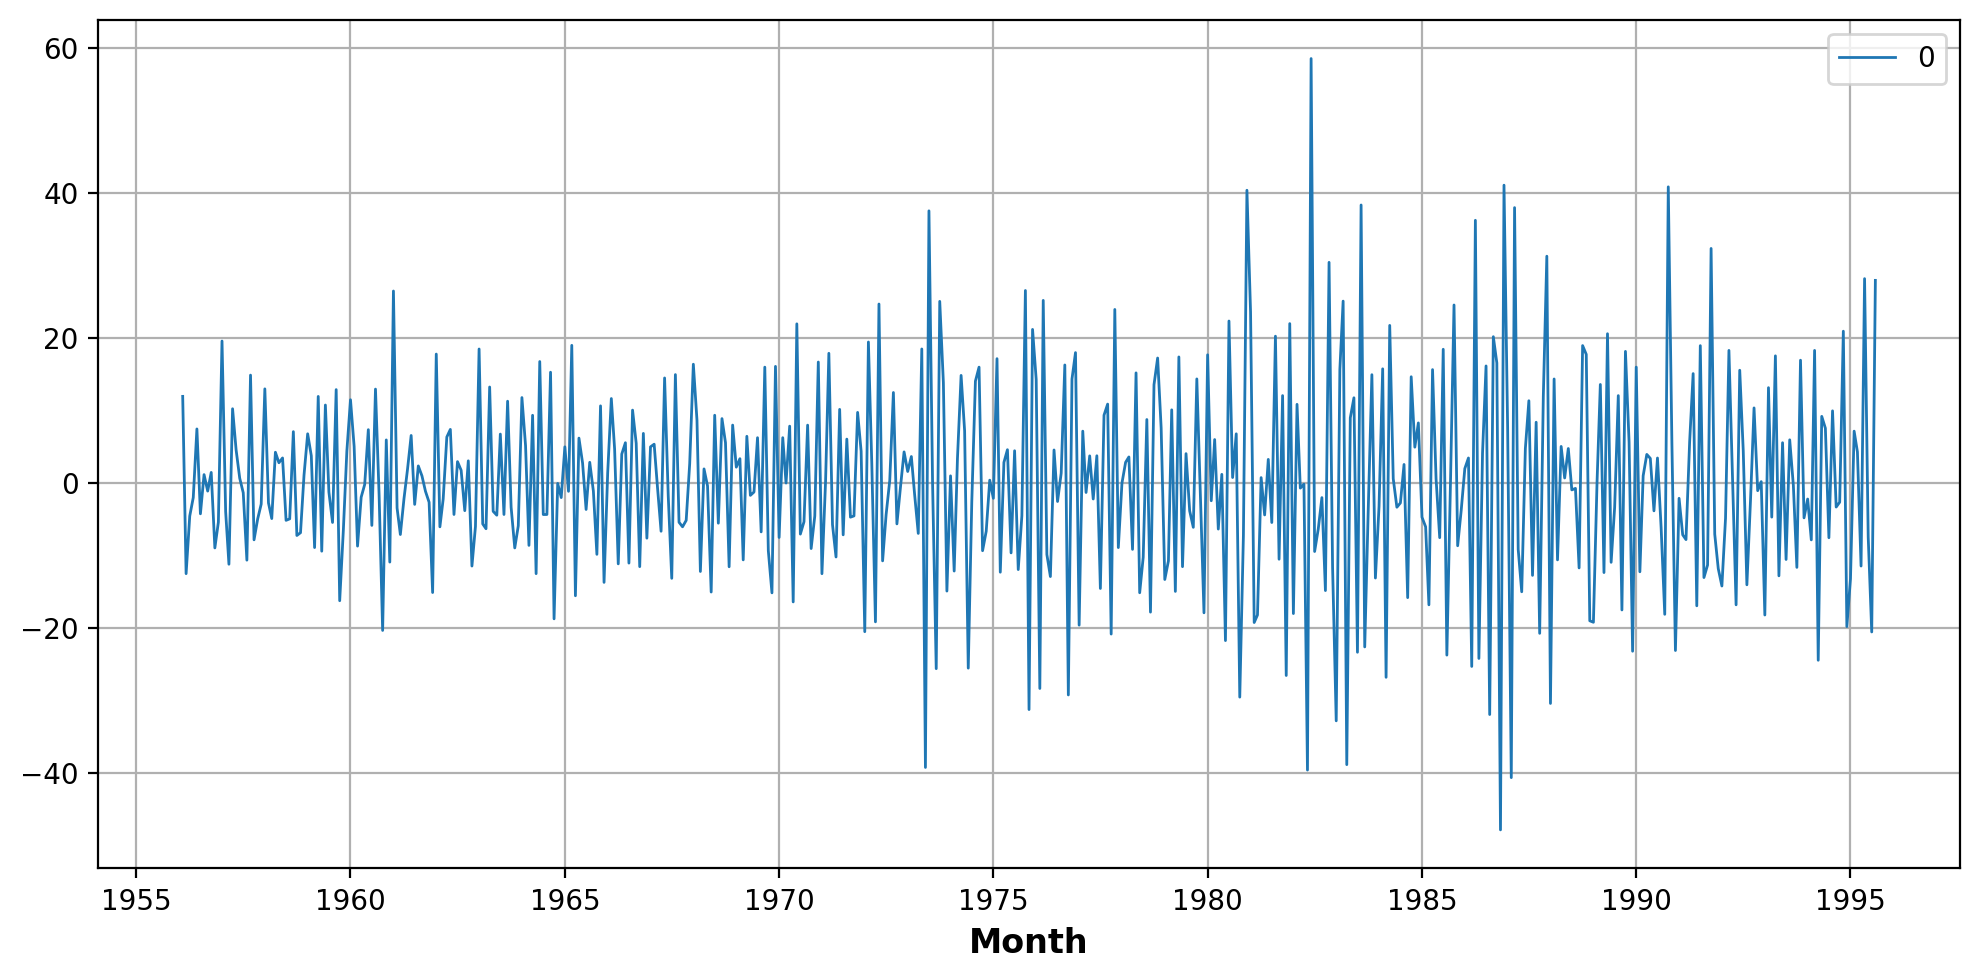

In [76]:
plt.figure(figsize = (10, 5))
diff = df_close.diff() #.diff()
diff = diff.dropna() # since the value being represented is the difference between 2 consecutive values, 
                     # the first value is NaN since it has no previous value 
sns.lineplot(data=diff,
             color="red",
             linewidth=1)
plt.grid()
print("Result of ADF test on closing data of difference order 1: \n")
adf = adfuller(diff, autolag = 'AIC')
output = pd.Series(adf[0:4], index = ['Test Stats', 'p-value', 'No. lags used', 'No. observations used'])
for key, values in adf[4].items():
    output['critical value (%s)' %key] = values
print(output)

At the difference of order 1, the significance p-value is close to zero, the level of significance is presented, the original null hypothesis is rejected, and the time series is now smooth. 

Financial time series are characterized by “clustered” and “persistent” return
volatility, and their time series errors do not always satisfy the homoscedasticity
assumption


### ACF - Divining the Q order that corresponds to the MA component

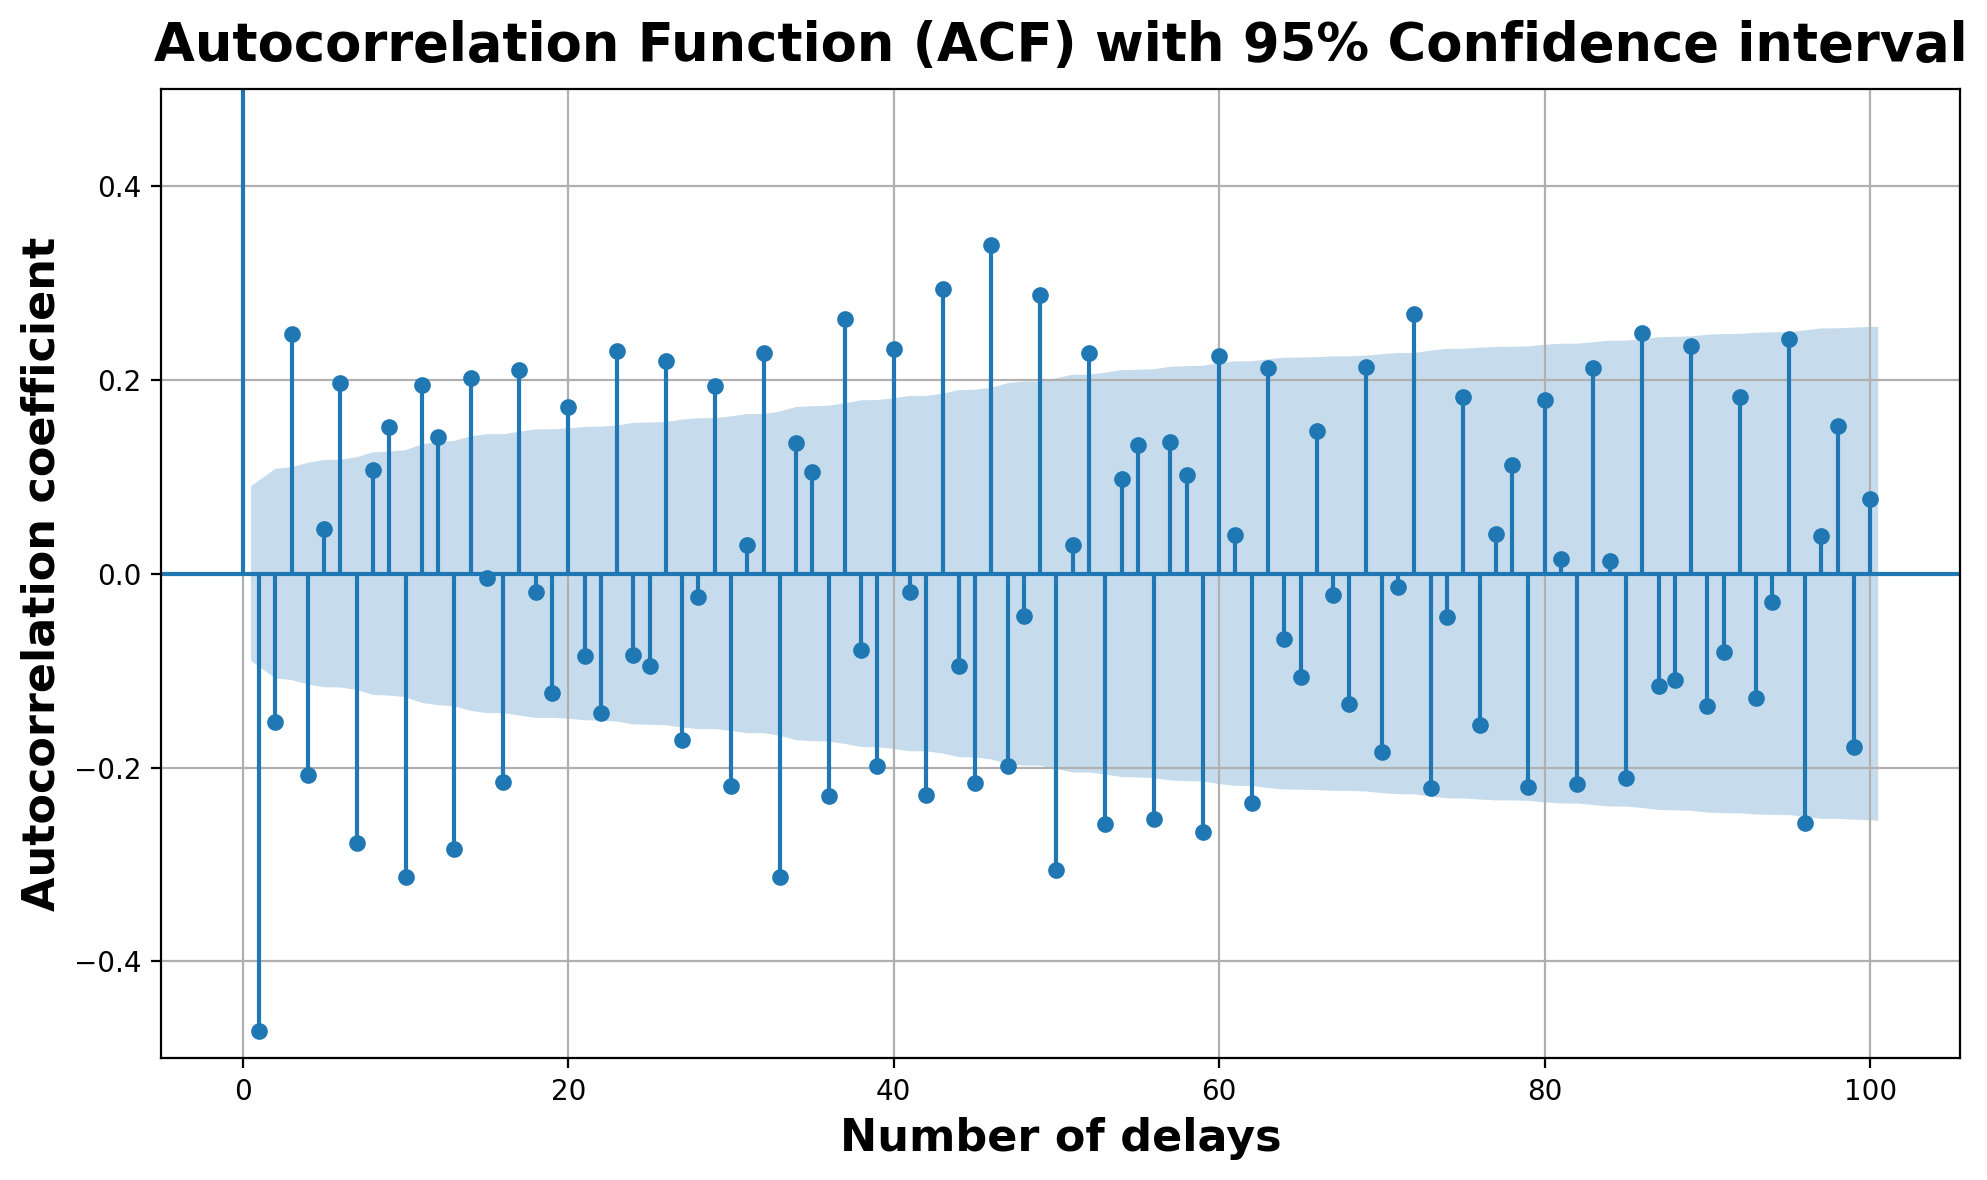

In [77]:
acf_diff, confdint_diff = sm.tsa.acf(diff, alpha = 0.05, nlags = 50)

fig, ax = plt.subplots(figsize = (10, 6))
tsaplots.plot_acf(diff, ax = ax, lags = 100, alpha = 0.05)
# ax.fill_between(confdint_diff[:, 0], confdint_diff[:, 1], color = 'gray')

ax.set_ylim([-0.5, 0.5])
ax.set_xlabel('Number of delays', fontsize = 16)
ax.set_ylabel('Autocorrelation coefficient', fontsize = 16)
ax.set_title('Autocorrelation Function (ACF) with 95% Confidence interval', fontsize = 19)
plt.grid()
plt.show()

### PACF - Divining the p order that corresponds to the AR component

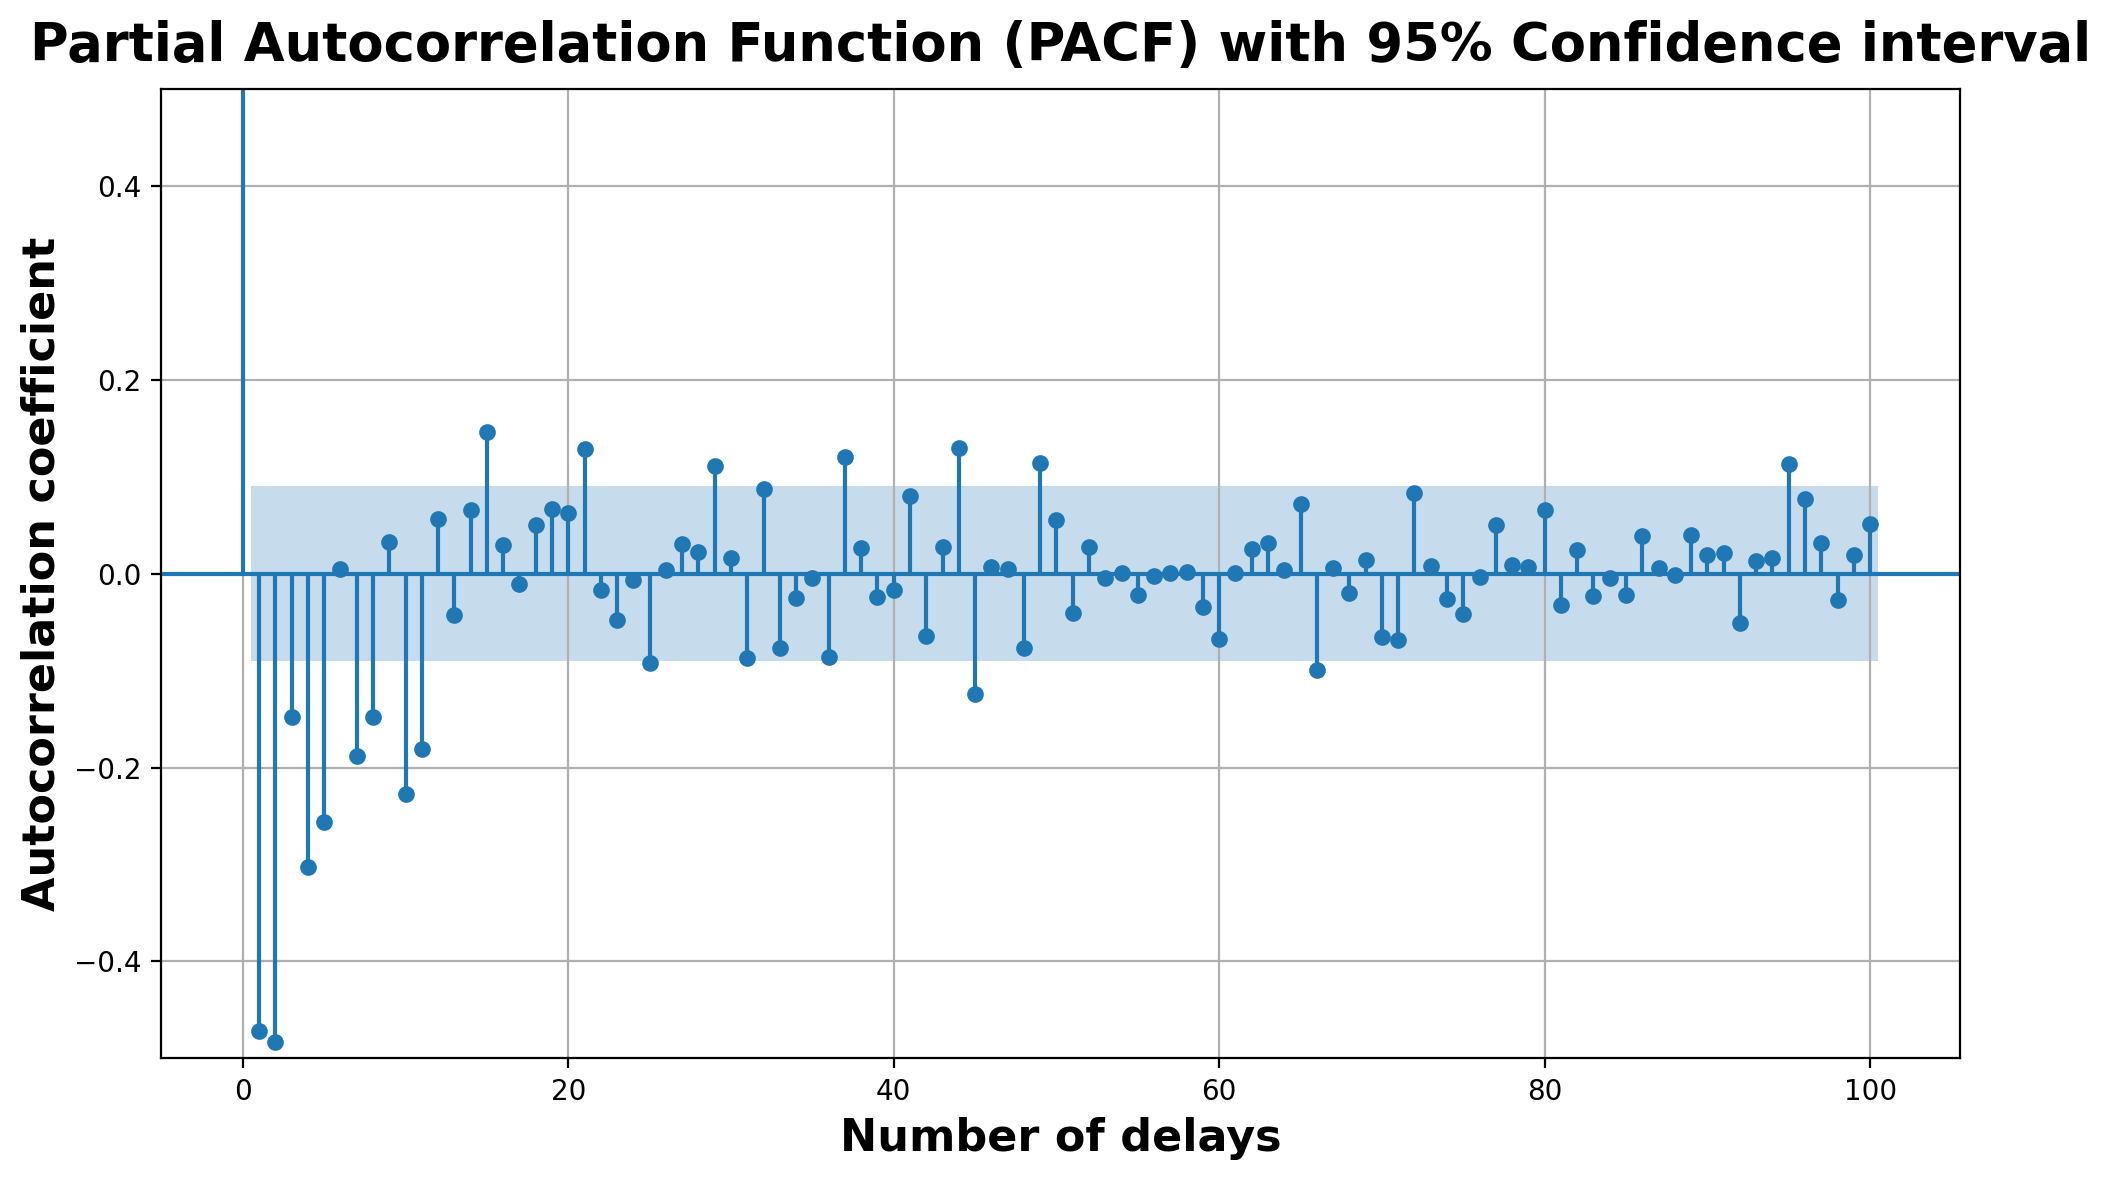

In [78]:
pacf_diff, confdint_diff = sm.tsa.pacf(diff, alpha = 0.05, nlags = 50)

fig, ax = plt.subplots(figsize = (10, 6))
tsaplots.plot_pacf(diff, ax = ax, lags = 100, alpha = 0.05)
# ax.fill_between(confdint_diff[:, 0], confdint_diff[:, 1], color = 'gray')

ax.set_ylim([-0.5,0.5])
ax.set_xlabel('Number of delays', fontsize = 16)
ax.set_ylabel('Autocorrelation coefficient', fontsize = 16)
ax.set_title('Partial Autocorrelation Function (PACF) with 95% Confidence interval', fontsize = 19)

plt.grid()
plt.show()

# Train test split

In [110]:
# split 90/10
train = df_close[:460] #.diff()
test = df_close[460:] #.diff()

In [111]:
test.index

DatetimeIndex(['1994-05-01', '1994-06-01', '1994-07-01', '1994-08-01',
               '1994-09-01', '1994-10-01', '1994-11-01', '1994-12-01',
               '1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')

In [35]:
# a = pd.Series(test_forecast.predicted_mean)
# a.index = test.index
# a

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  460
Model:                 ARIMA(4, 1, 9)   Log Likelihood               -1642.246
Date:                Wed, 31 Jul 2024   AIC                           3312.493
Time:                        17:59:53   BIC                           3370.299
Sample:                    01-01-1956   HQIC                          3335.258
                         - 04-01-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0754      0.041      1.838      0.066      -0.005       0.156
ar.L2         -0.4261      0.036    -11.937      0.000      -0.496      -0.356
ar.L3          0.2458      0.033      7.348      0.0

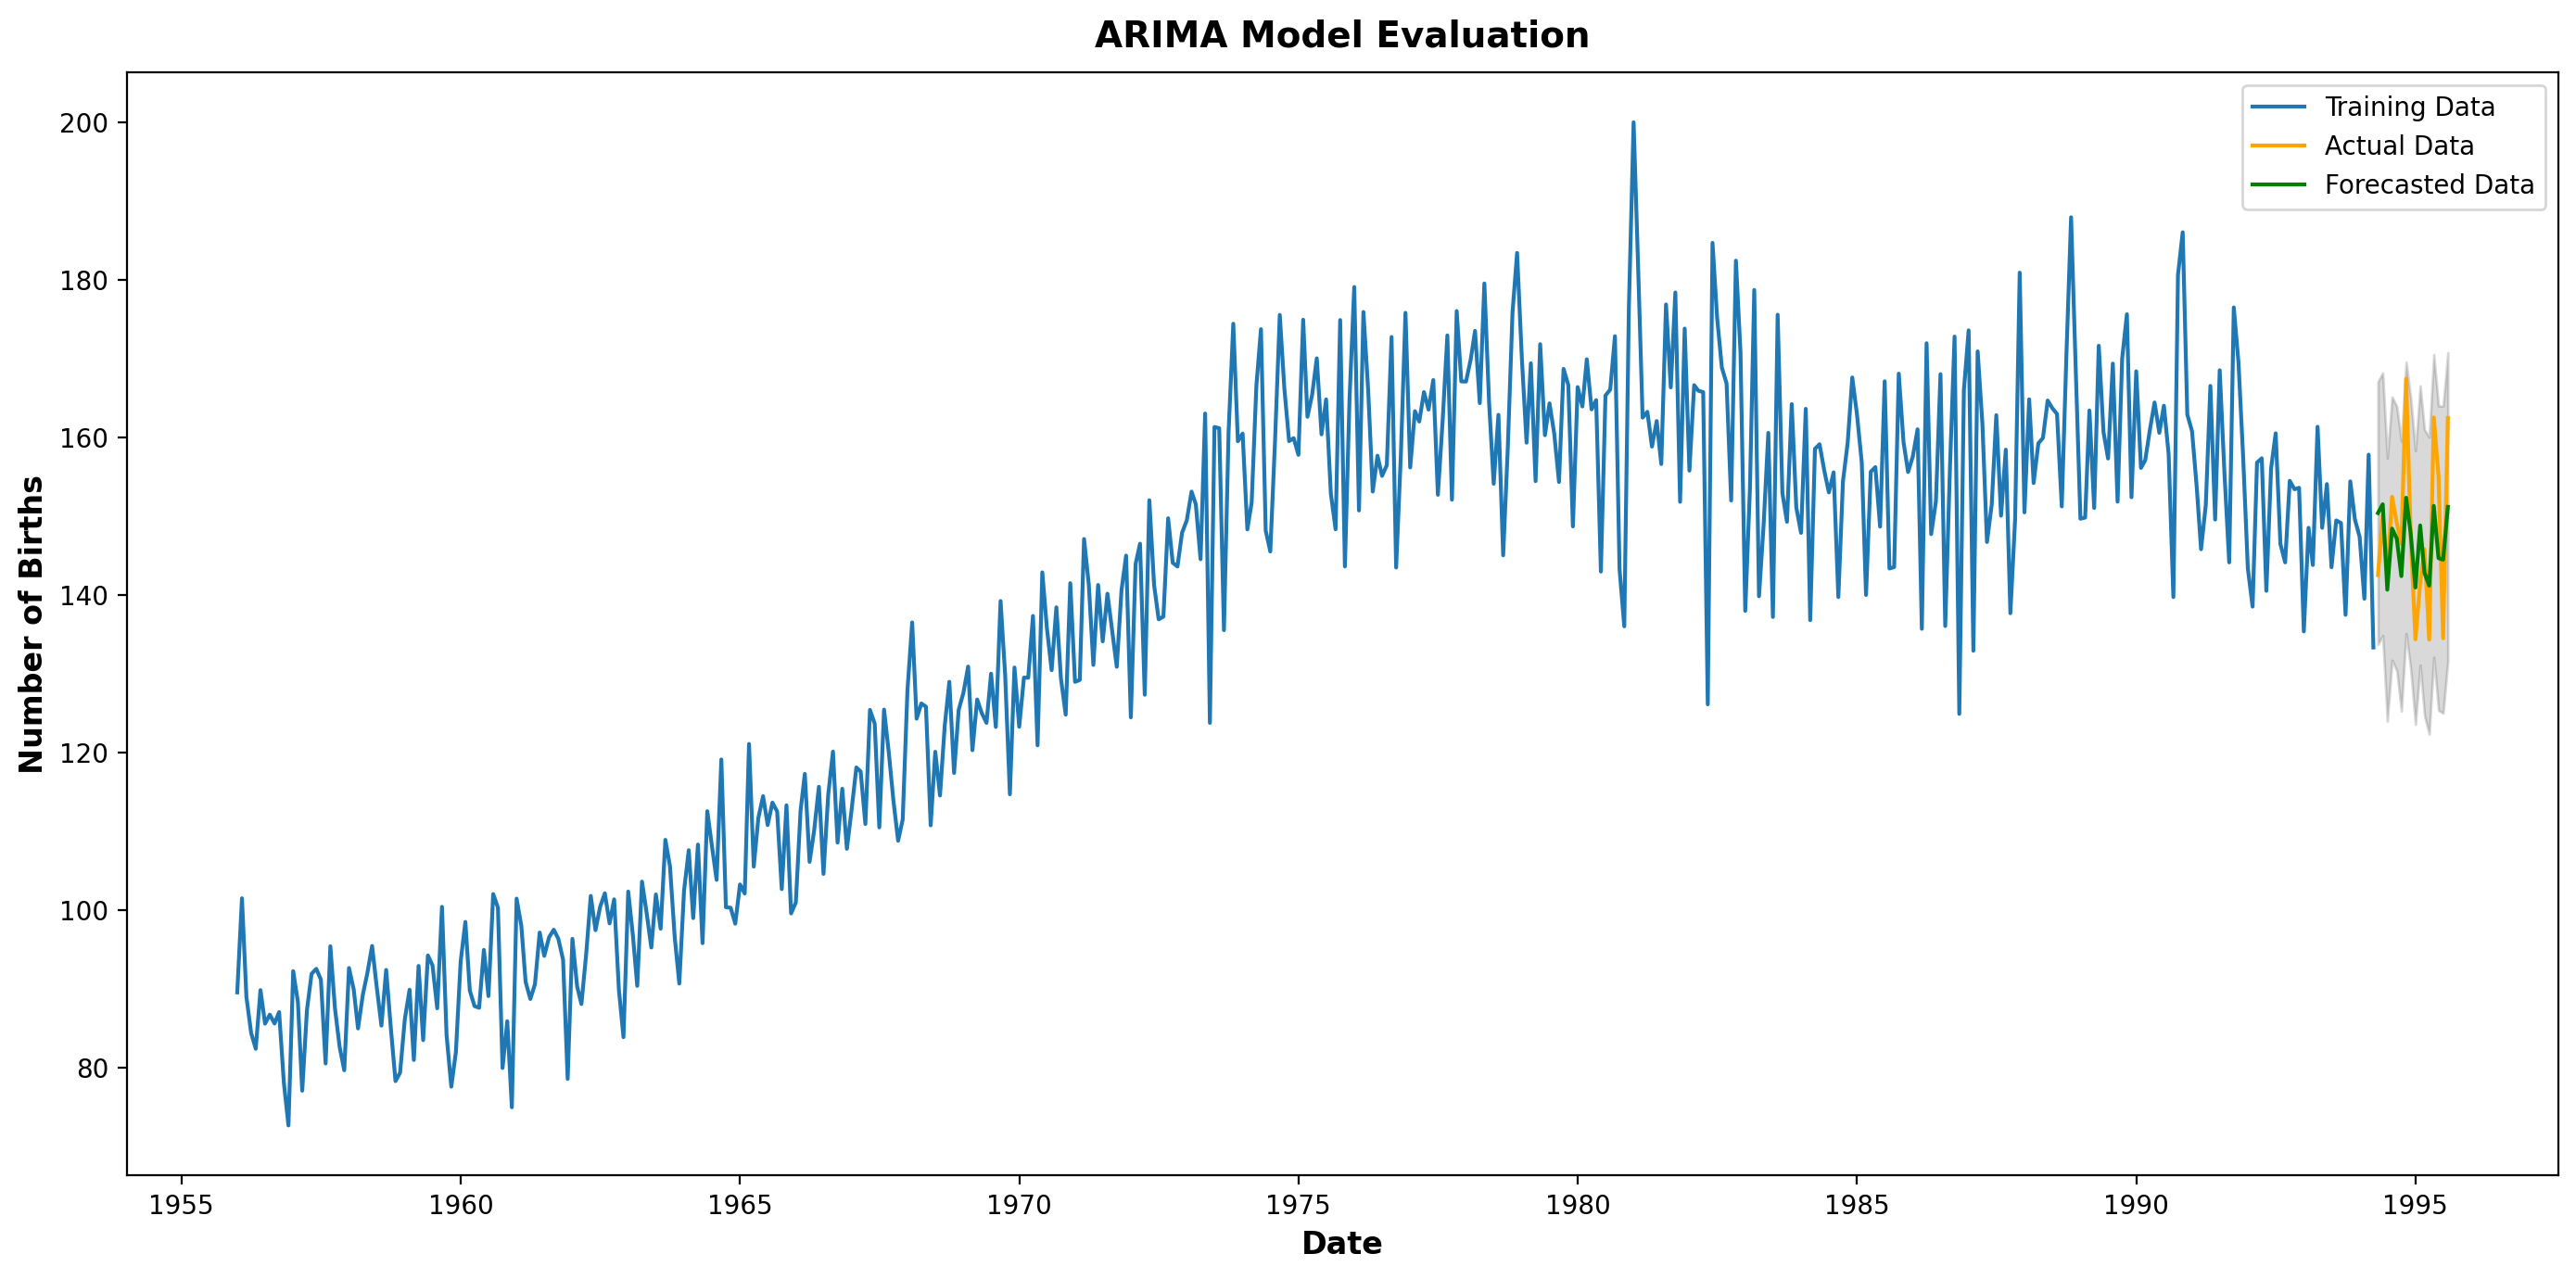

In [116]:
model_train = ARIMA(train[0], order=([i for i in range(1,5)], 1, [i for i in range(1,10)]))
model_train_fit = model_train.fit()
print(model_train_fit.summary())
    
test_forecast = model_train_fit.get_forecast(steps=len(test[0]))
a = pd.Series(test_forecast.predicted_mean)
a.index = test.index
a

plt.figure(figsize=(14,7))
plt.plot(train[0], label='Training Data')
plt.plot(test[0], label='Actual Data', color='orange')
plt.plot(a, label='Forecasted Data', color='green')
plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

In [ ]:
#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#
#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#

#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#

#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#
#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#
#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#
#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#
#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#
#sdklfjsdjfsdjfklsdjflaskdjjlkjvalkfj ọe godfjg k;dlf gldfjg ljro;ijgoifdjig dfg f#